In [1]:
'''
Prepare parameters for model based on deisgn and measurement conditions
Unit: mm
Author: Yitian Shao
Created on 2022.01.17
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

try:
    EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity
except:
    EPSILON0 = 0.0000000000088541878128

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))


c shared library imported successfully!
Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [53]:
''' Condition table '''
# Layout: %d - number of dashes dividing rectangle column, T - extra triangle column, - R - an extra rectangle cell
colNames = ['CondiName','Shell','ls_um','Fluid','Infill_mL','DashLength_mm','FlatDashDist_mm','DashSpace_mm','Layout',
            'triNum','rectNum','TubeLength_mm','TubeInnerDia_mm','VoltPolar','Voltage_V','HVSupply','Info']

''' For data collected before 2022.04 '''
condiTable = [
    ['6mLBOPP12',           'BOPP',20,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLBOPP16',           'BOPP',20,'IC',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,6-2,'Uni',8800,'Wearable','20210719_RigidTube'],
    ['6mLL0Ws12SoftTube','PETL0Ws',30,'IC',6,12,10,12.66,'6T5T4T3T2T1T',48,27,150,4,'Uni',8800,'Wearable','20210719_SoftTube'],
    ['BOPP16ShiftedU7kV',   'BOPP',20,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210729_RigidTube'],
    ['L0Ws16ShiftedU9kV','PETL0Ws',30,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['L0Ws16NoShift',    'PETL0Ws',30,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210729_RigidTube'],
    ['Mylar16',            'Mylar',15,'IC',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['Mylar16NoShift',     'Mylar',15,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16',              'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP20',              'BOPP',20,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Uni',7200,'Wearable','20210728_RigidTube'],
    ['BOPP16U9kV',          'BOPP',20,'IC',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Uni',8800,'Wearable','20210728_RigidTube'],
    ['MLSi16SB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'5T4T3T2T1TRT',36,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16S'],
    ['MLSi16CB7kV',  'Mylar',15,'Silicone',6,16,10,8.66,'T5T4T3T2T1TR',48,21,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_16C'],
    ['MLSi20SB7kV',  'Mylar',15,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube_20S'],
    ['MLSi20B7kV',   'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,6-2,'Bi',7000,'Trek','20210813_RigidTube'],
    ['Tube6mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,35,6-2,'Bi',6900,'Wearable','20210924'],
    ['MedTubePressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['PressBalloon2',      'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20210924'],
    ['Tube8mmPressBalloon','Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['Pressure',           'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20210924'],
    ['FR3Tube8mm',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,8-2,'Bi',6900,'Wearable','20211008'],
    ['FR3MedTube',         'Mylar',15,'IC',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['SiMedTube',    'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,3.2,'Bi',6900,'Wearable','20211008'],
    ['L0WsSi5-20Trek8kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',8000,'Trek','20220302'],
    ['L0WsSi5-20Trek9kV',      'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi5-20Trek10kV',     'L0Ws',20,'Silicone',6,20,10,8.66,'T5T4T3T2T1',45,20,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi6-16Trek9kVHVTop', 'L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',9000,'Trek','20220302'],
    ['L0WsSi6-16Trek10kVHVTop','L0Ws',20,'Silicone',6,16,10,8.66,'6T5T4T3T2T1T',48,27,150,4.0,'Bi',10000,'Trek','20220302'],
    ['L0WsSi5-20sTrek9kVHVBot','L0Ws',20,'Silicone',6,20,10,8.66,'5T4T3T2T1T',37,20,150,4.0,'Bi',9000,'Trek','20220302'],
]

''' For data collected since 2022.04 '''
condiTable = [
    ['MLSi20HV7kV.5Hz',       'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV1Hz',        'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    
    ['MLSi20HV7kV10mL1Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL2Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL4Hz',  'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL10Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL20Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    
    ['MLSi20HV7kV6mL.5Hz',  'Mylar',15,'Silicone',6,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV7mL.5Hz',  'Mylar',15,'Silicone',7,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV8mL.5Hz',  'Mylar',15,'Silicone',8,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402'],
    ['MLSi20HV7kV10mL.5Hz', 'Mylar',15,'Silicone',10,20,10,8.66,'T5T4T3T2T',45,18,150,4.0,'Bi',7000,'Trek','20220402']
]

condiTable = pd.DataFrame(condiTable, columns = colNames)
condiTable.to_csv("ConditionTable.csv", index=False)

colNames2 = ['Material','DieConstant','DieStrength_V/um','Density_kg/m3','Viscosity_mm2/s']
materialProperty = [['BOPP',2.2,700,float('nan'),float('nan')],['Mylar',3.2,276,float('nan'),float('nan')],
                    ['L0Ws',3,float('nan'),float('nan'),float('nan')],
                    ['IC',3.2,20,920,34],['Silicone',2.6,15,920,5]]
materialProperty = pd.DataFrame(materialProperty, columns = colNames2)
# materialProperty.to_csv("MaterialProperty.csv", index=False)

In [3]:
'''
General Functions
'''

def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassFilter(datain, cutFreq, Fs, order):
    b, a = signal.butter(order, 2 * cutFreq / Fs, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeFileName(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    return condi, names, trialNum

def decodeFileName2(fileName):
    condi = re.split('_|\.csv', fileName)[3:5]
    names = condi[0]         
    trialNum = int(re.split('t', condi[1])[-1])
    
    print(names)
    freq = None
    freqInfo = re.findall('[\.]*\d+Hz', names)
    if freqInfo:
        freq = float(re.split('Hz', freqInfo[0])[0])
        print("Signal frequency (Hz) = %.3f" % freq)
    
    return condi, names, trialNum, freq

''' Identify pressure increasing duration and compute time-averaged pressure '''
def processPressure(rawData, Fs, inactivePressure, cutOff=5, order=8):   
    print(rawData.shape)
    print(np.max(rawData))
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
        
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    samp = np.arange(len(rawData))
    ax0, _ = aPlot("Truncat")
    ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
    ax0.plot(samp, filtData, color='tab:blue')
    
    zipStart = samp[0]
    zipEnd = samp[-1]
    
    try:
        zipStart = np.nonzero(filtData > 0.25 * maxFiltPress)[0][0]
        ax0.plot([zipStart,zipStart], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the start of zipping process")

    try:
        zipEnd = np.argmax(filtData)
        ax0.plot([zipEnd,zipEnd], [0, maxFiltPress], '--k')
    except:
        print("Unable to identify the end of zipping process")
        
    plt.show()
    
    avgPressure = np.mean(rawData[zipStart:zipEnd+1] - inactivePressure)
    
    deltaT = (zipEnd - zipStart) / Fs
    
    maxPressure = rawData[zipEnd] - inactivePressure # Maximum steady state pressure
    peakPressure = np.max(rawData) - inactivePressure # Peak pressure reachable
    
    return avgPressure, deltaT, peakPressure, np.array([zipStart, zipEnd])

''' 
(For different signal frequency of repeated measurement) 
Identify pressure increasing duration and compute time-averaged pressure 
'''
def cutRepeatTrial(rawData, Fs, inactivePressure, cutOff=5, order=8): 
    print(rawData.shape)
    maxRawValue = np.max(rawData)
    print("max value of raw data = %.3f" % maxRawValue)
    filtData = lowpassFilter(rawData, cutOff, Fs, order) - inactivePressure
    
    samp = np.arange(len(rawData))
    
    maxFiltPress = np.max(filtData) 
    print(maxFiltPress)
    
    segPointInd = np.squeeze(np.argwhere(filtData > 0.25 * maxFiltPress)) # Find value larger than 25% of peak as valid segment data point
    
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > 1))# Index of point where large gap occurs (end and start of a seg)
    print(segPointInd[segGapInd]) # End index of a segment
    print(segPointInd[segGapInd+1]) # Start index of a segment
    
    cutInd = (0.5 * (segPointInd[segGapInd] + segPointInd[segGapInd+1])).astype(int) # Cut in the middle of a end and a start point
    
    avgSegLen = np.mean(np.diff(cutInd))
    print("Avg. segment length = %d" % avgSegLen)
    
    cutInd = np.insert(cutInd, 0, max(cutInd[0]-avgSegLen, 0))
    
    ''' Plot data segmentation index '''
#     ax0, _ = aPlot("Cut Segments")
#     ax0.plot(samp, rawData -inactivePressure, color='tab:orange')
#     ax0.plot(samp[segPointInd], filtData[segPointInd], color='tab:blue')
#     ax0.plot(cutInd, np.zeros(cutInd.shape), '*g')
#     plt.show()
    return cutInd


In [13]:
''' 
Design and zipping state (Rerun needed only when adding a new design layout) 
'''
colNames3 = ['Layout','triNum','rectNum','triNum1Expan','rectNum1Expan','triNum2Expan','rectNum2Expan']

stateLayout = [
    ['6T5T4T3T2T1T', 48,27, -12,-6, -23,-12],
    ['5T4T3T2T1TRT', 36,21, -12,-6, -21,-11],
    ['T5T4T3T2T1', 45,20, -10,-5, -20,-10],
    ['T5T4T3T2T1TR', 48,21, -12,-6, -23,-11],
    ['5T4T3T2T1T', 37,20, -10,-5, -19,-10],
    ['T5T4T3T2T', 45,18, -10,-4, -19,-8]
]

stateLayout = pd.DataFrame(stateLayout, columns = colNames3)
# stateLayout.to_csv("StateLayout.csv", index=False)

''' 
Generate model by matched parameters after getting model data of Valid Arc Length 
(Rerun needed only when adding a new design layout) 
'''
md = pd.read_csv("./data/ValidArcLength.csv")
dataLen = md.shape[0]
print("Data contains %d rows" % dataLen)

''' Get total volume of design structures for inactive and zipped state '''
# stateLayout = pd.read_csv("./data/StateLayout.csv")
stateLayout.head()

''' Compute total volume based on pouch design and zipping state '''
for layout_i in stateLayout['Layout']:
    ind = (stateLayout['Layout'] == layout_i)
    md[layout_i] = stateLayout.loc[ind,'triNum'].iloc[0] * md['triVol'] + stateLayout.loc[ind,'rectNum'].iloc[0] * md['rectVol']

# md.to_csv("ValidArcLength.csv", index=False)
md.head(1)   

Data contains 1914 rows


dashHalfDist  dashSpace         R    triArc      triVol     rectVol  \
0           4.5      12.66  8.425705  9.999566  171.949277  138.938526   

   dashLength  6T5T4T3T2T1T  5T4T3T2T1TRT    T5T4T3T2T1  T5T4T3T2T1TR  \
0        12.0  12004.905481   9107.883005  10516.487969  11171.274325   

    5T4T3T2T1T     T5T4T3T2T  
0  9140.893756  10238.610918

In [ ]:
'''Measurement 2022 Duel Trial'''
# pressData = []
# Fs = 1000
# beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
# endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)

# for root, directories, files in walk(".\data\DualTrial"):
#     for fileName in files:
#          if (fileName[-3:] == 'csv'):    
#                 condi, names, trialNum = decodeFileName(fileName)
                
#                 data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
#                 data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
#                 dataMin = np.min(data) 
#                 if dataMin < 0:
#                     data = data-dataMin # Rectify data

#                 inactivePressure = np.min(data[:int(0.5*Fs)])

#                 for i in range(len(beginInd)): 
#                     avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
#                     P0 = data[beginInd[i]+segInd[0]]-inactivePressure

#                     print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
#                     print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
#                           (avgPressure, maxPressure, deltaT))
#                     pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
#                                     (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa


MLSi20HV7kV6mL.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.10744385375939378
0.10469573803933609


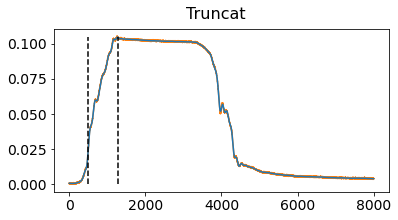


MLSi20HV7kV6mL.5Hz - Trial07 - Seg1
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.105 (bar) in 0.384 (sec)

(8000,)
0.10402779293520484
0.101397469104781


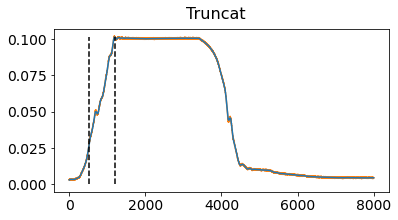


MLSi20HV7kV6mL.5Hz - Trial07 - Seg2
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.102 (bar) in 0.343 (sec)

(8000,)
0.14534127971037242
0.13739432063523752


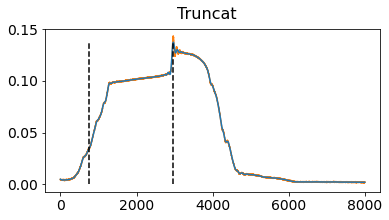


MLSi20HV7kV6mL.5Hz - Trial07 - Seg3
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.143 (bar) in 1.111 (sec)

(8000,)
0.11706656030640486
0.11401071800697292


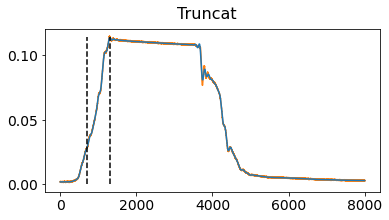


MLSi20HV7kV6mL.5Hz - Trial07 - Seg4
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.115 (bar) in 0.298 (sec)

(8000,)
0.14471580378481672
0.13789752852268658


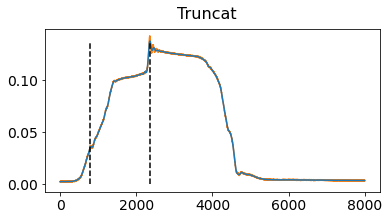


MLSi20HV7kV6mL.5Hz - Trial07 - Seg5
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.143 (bar) in 0.790 (sec)

(8000,)
0.15212528782601525
0.14249855544928197


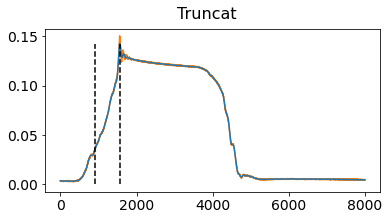


MLSi20HV7kV6mL.5Hz - Trial07 - Seg6
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.150 (bar) in 0.327 (sec)

(8000,)
0.1505375412457584
0.14095680771935093


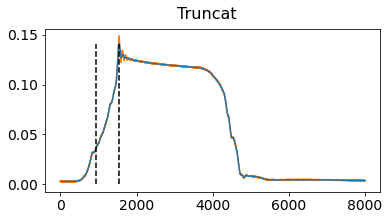


MLSi20HV7kV6mL.5Hz - Trial07 - Seg7
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.148 (bar) in 0.307 (sec)

(8000,)
0.15233377980120047
0.1411326701282932


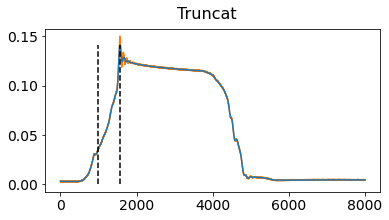


MLSi20HV7kV6mL.5Hz - Trial07 - Seg8
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.150 (bar) in 0.288 (sec)

(8000,)
0.14016105601923146
0.12964796407800702


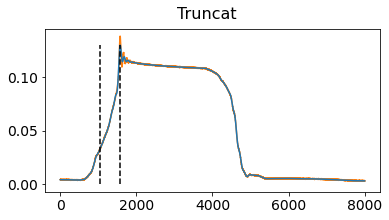


MLSi20HV7kV6mL.5Hz - Trial07 - Seg9
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.138 (bar) in 0.269 (sec)

(8000,)
0.1481639402974957
0.13651008009575613


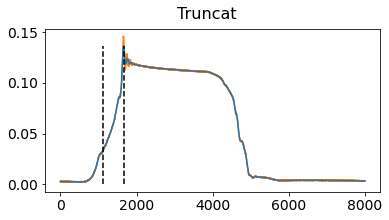


MLSi20HV7kV6mL.5Hz - Trial07 - Seg10
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.146 (bar) in 0.266 (sec)

(8000,)
0.1369695250144728
0.12552037576664907


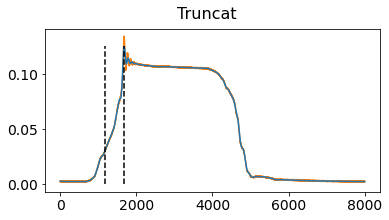


MLSi20HV7kV6mL.5Hz - Trial07 - Seg11
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.135 (bar) in 0.247 (sec)

(8000,)
0.11764392269922552
0.10829238334774065


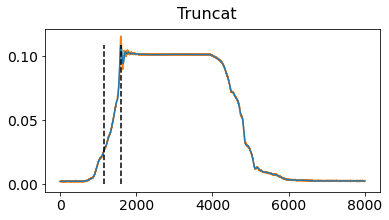


MLSi20HV7kV6mL.5Hz - Trial07 - Seg12
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.116 (bar) in 0.218 (sec)

(8000,)
0.11291275864694507
0.11034756879091037


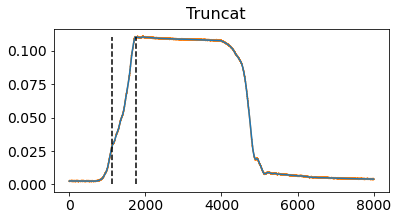


MLSi20HV7kV6mL.5Hz - Trial07 - Seg13
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.111 (bar) in 0.317 (sec)

(8000,)
0.10919197878210078
0.10609266359560704


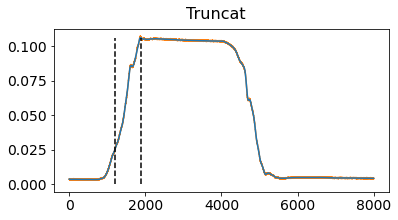


MLSi20HV7kV6mL.5Hz - Trial07 - Seg14
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.107 (bar) in 0.331 (sec)

(8000,)
0.10883914620871038
0.10601712002579733


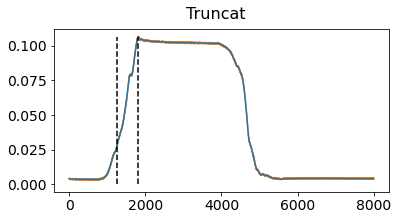


MLSi20HV7kV6mL.5Hz - Trial07 - Seg15
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.107 (bar) in 0.285 (sec)

(8000,)
0.108502351479565
0.1056219896980153


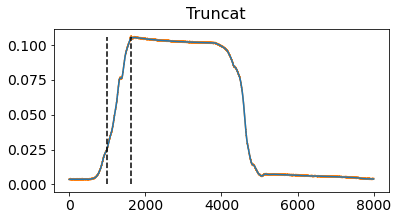


MLSi20HV7kV6mL.5Hz - Trial07 - Seg16
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.106 (bar) in 0.315 (sec)

(8000,)
0.10657781017016277
0.10406316841578919


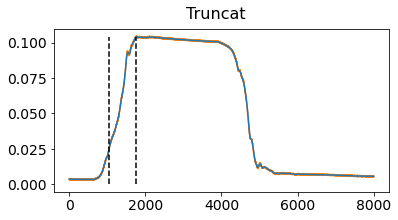


MLSi20HV7kV6mL.5Hz - Trial07 - Seg17
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.105 (bar) in 0.354 (sec)

(8000,)
0.09374753477414799
0.09110737712781913


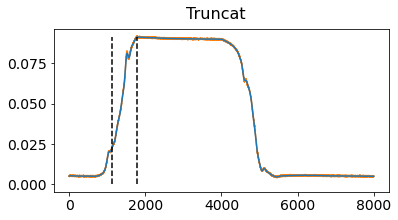


MLSi20HV7kV6mL.5Hz - Trial07 - Seg18
Avg. Pressure of zipping = 0.062 (bar), Max. P. = 0.092 (bar) in 0.332 (sec)

MLSi20HV7kV7mL.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.15799513881969202
0.15235678608856243


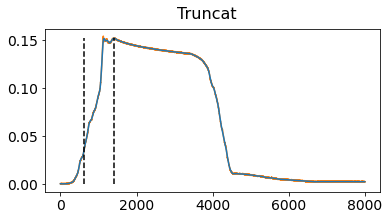


MLSi20HV7kV7mL.5Hz - Trial08 - Seg1
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.154 (bar) in 0.389 (sec)

(8000,)
0.11791656605139084
0.11393688298878178


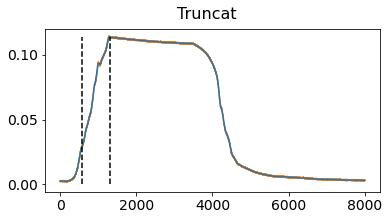


MLSi20HV7kV7mL.5Hz - Trial08 - Seg2
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.114 (bar) in 0.367 (sec)

(8000,)
0.114596732292672
0.11059225924358711


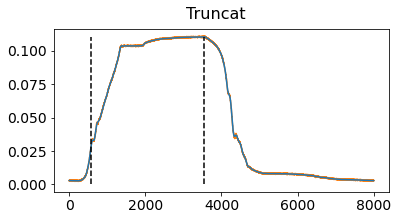


MLSi20HV7kV7mL.5Hz - Trial08 - Seg3
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.111 (bar) in 1.487 (sec)

(8000,)
0.11995337227050817
0.11599126117251528


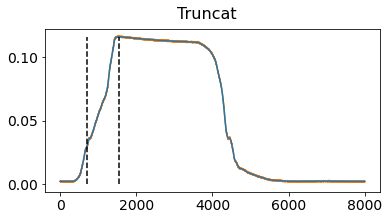


MLSi20HV7kV7mL.5Hz - Trial08 - Seg4
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.116 (bar) in 0.422 (sec)

(8000,)
0.1106033090756624
0.10657712855920447


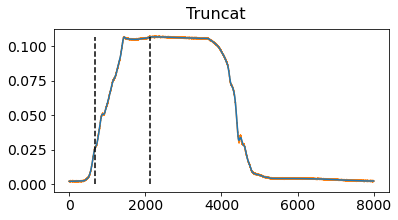


MLSi20HV7kV7mL.5Hz - Trial08 - Seg5
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.107 (bar) in 0.722 (sec)

(8000,)
0.11908732868127718
0.11504678565605271


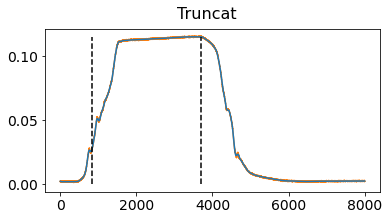


MLSi20HV7kV7mL.5Hz - Trial08 - Seg6
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.116 (bar) in 1.425 (sec)

(8000,)
0.11847789059996648
0.11465613308892347


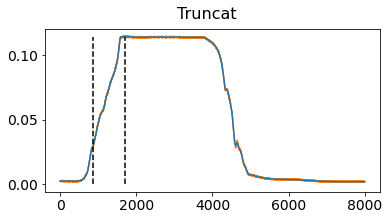


MLSi20HV7kV7mL.5Hz - Trial08 - Seg7
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.115 (bar) in 0.421 (sec)

(8000,)
0.12373830351233255
0.11970495955234299


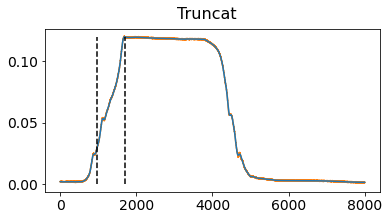


MLSi20HV7kV7mL.5Hz - Trial08 - Seg8
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.120 (bar) in 0.360 (sec)

(8000,)
0.11764392269922552
0.1135885575549034


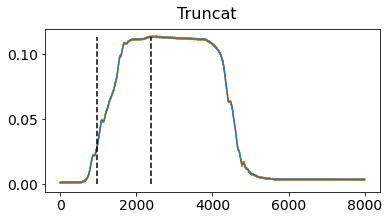


MLSi20HV7kV7mL.5Hz - Trial08 - Seg9
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.114 (bar) in 0.717 (sec)

(8000,)
0.12152508100651999
0.11749030659538712


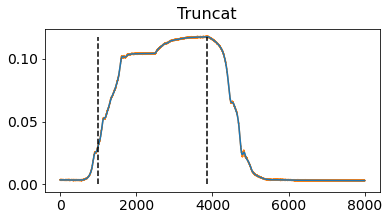


MLSi20HV7kV7mL.5Hz - Trial08 - Seg10
Avg. Pressure of zipping = 0.100 (bar), Max. P. = 0.118 (bar) in 1.440 (sec)

(8000,)
0.1191835557467473
0.11516118066783354


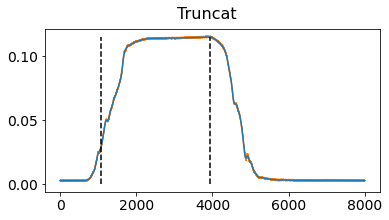


MLSi20HV7kV7mL.5Hz - Trial08 - Seg11
Avg. Pressure of zipping = 0.103 (bar), Max. P. = 0.116 (bar) in 1.435 (sec)

(8000,)
0.11960053969711777
0.11545360799823383


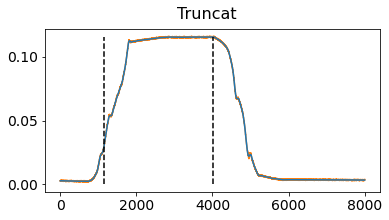


MLSi20HV7kV7mL.5Hz - Trial08 - Seg12
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.116 (bar) in 1.439 (sec)

(8000,)
0.11822128509204619
0.11411952981485307


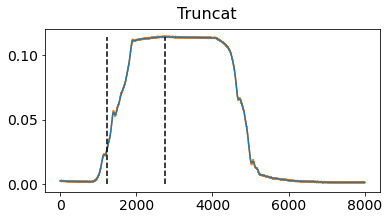


MLSi20HV7kV7mL.5Hz - Trial08 - Seg13
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.115 (bar) in 0.759 (sec)

(8000,)
0.11785241467441077
0.11365754102106214


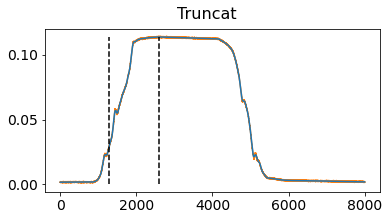


MLSi20HV7kV7mL.5Hz - Trial08 - Seg14
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.114 (bar) in 0.659 (sec)

(8000,)
0.11796467958412589
0.11395585711338134


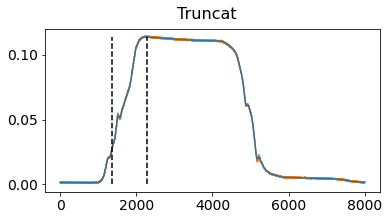


MLSi20HV7kV7mL.5Hz - Trial08 - Seg15
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.114 (bar) in 0.458 (sec)

(8000,)
0.11842977706723143
0.11434668216969394


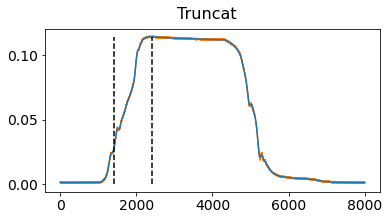


MLSi20HV7kV7mL.5Hz - Trial08 - Seg16
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.115 (bar) in 0.501 (sec)

(8000,)
0.11826939862478124
0.11422062631013924


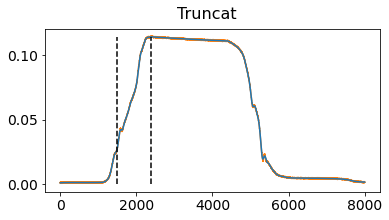


MLSi20HV7kV7mL.5Hz - Trial08 - Seg17
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.115 (bar) in 0.446 (sec)

(8000,)
0.11966469107409784
0.11578016134664741


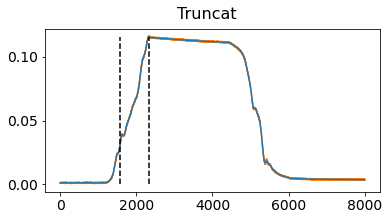


MLSi20HV7kV7mL.5Hz - Trial08 - Seg18
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.116 (bar) in 0.388 (sec)

MLSi20HV7kV8mL.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.1505215034015134
0.14366864441693913


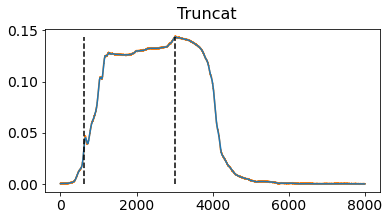


MLSi20HV7kV8mL.5Hz - Trial09 - Seg1
Avg. Pressure of zipping = 0.117 (bar), Max. P. = 0.144 (bar) in 1.201 (sec)

(8000,)
0.15610267319877982
0.14422990584363862


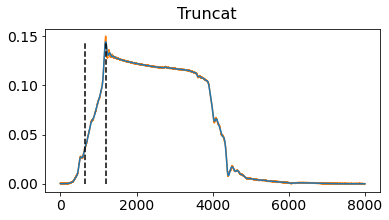


MLSi20HV7kV8mL.5Hz - Trial09 - Seg2
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.150 (bar) in 0.273 (sec)

(8000,)
0.11796467958412589
0.11125253701361837


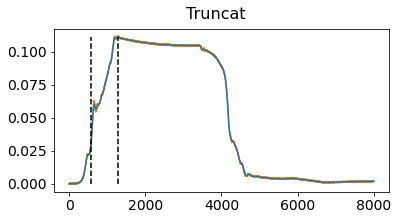


MLSi20HV7kV8mL.5Hz - Trial09 - Seg3
Avg. Pressure of zipping = 0.077 (bar), Max. P. = 0.112 (bar) in 0.363 (sec)

(8000,)
0.10997783315010669
0.1034148943226294


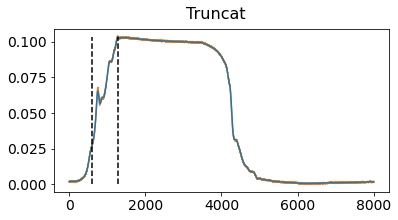


MLSi20HV7kV8mL.5Hz - Trial09 - Seg4
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.104 (bar) in 0.349 (sec)

(8000,)
0.09515886506770961
0.08847077638744949


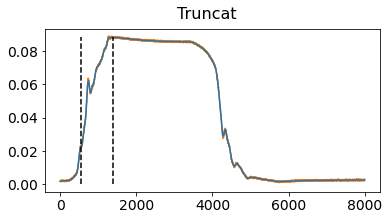


MLSi20HV7kV8mL.5Hz - Trial09 - Seg5
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.089 (bar) in 0.421 (sec)

(8000,)
0.09717963344258194
0.09056694884544668


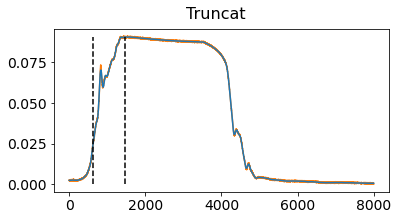


MLSi20HV7kV8mL.5Hz - Trial09 - Seg6
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.091 (bar) in 0.425 (sec)

(8000,)
0.14859696209211118
0.1347483629936742


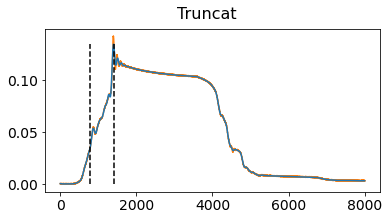


MLSi20HV7kV8mL.5Hz - Trial09 - Seg7
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.142 (bar) in 0.311 (sec)

(8000,)
0.09546358410836497
0.08896937885188802


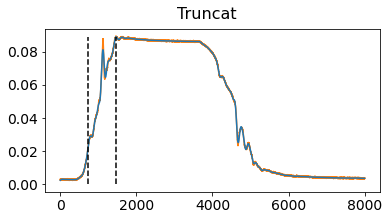


MLSi20HV7kV8mL.5Hz - Trial09 - Seg8
Avg. Pressure of zipping = 0.058 (bar), Max. P. = 0.089 (bar) in 0.368 (sec)

(8000,)
0.09767680661417752
0.09086311706719259


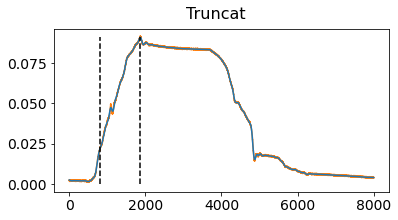


MLSi20HV7kV8mL.5Hz - Trial09 - Seg9
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.092 (bar) in 0.523 (sec)

(8000,)
0.12887041367073845
0.12227221851478948


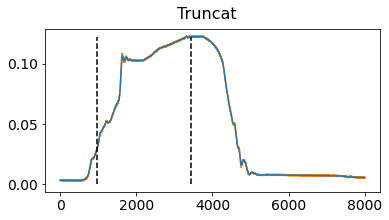


MLSi20HV7kV8mL.5Hz - Trial09 - Seg10
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.123 (bar) in 1.226 (sec)

(8000,)
0.08165500021340406
0.07501025884402288


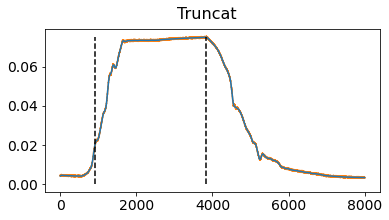


MLSi20HV7kV8mL.5Hz - Trial09 - Seg11
Avg. Pressure of zipping = 0.067 (bar), Max. P. = 0.076 (bar) in 1.464 (sec)

(8000,)
0.12210244339934066
0.11411497924596566


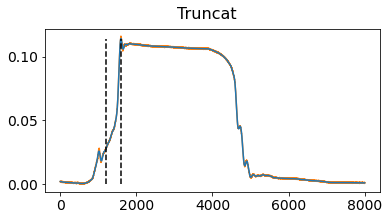


MLSi20HV7kV8mL.5Hz - Trial09 - Seg12
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.116 (bar) in 0.192 (sec)

(8000,)
0.13081099282438569
0.12188828366596444


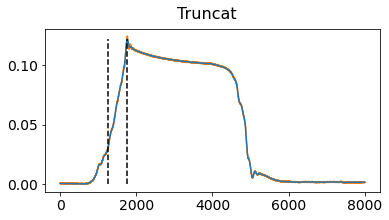


MLSi20HV7kV8mL.5Hz - Trial09 - Seg13
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.125 (bar) in 0.255 (sec)

(8000,)
0.12412321177421298
0.1180396245605703


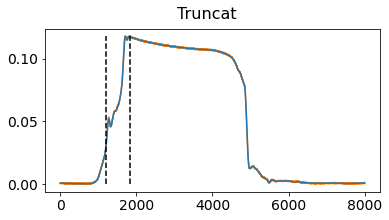


MLSi20HV7kV8mL.5Hz - Trial09 - Seg14
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.118 (bar) in 0.309 (sec)

(8000,)
0.14875734053456136
0.1419455251131483


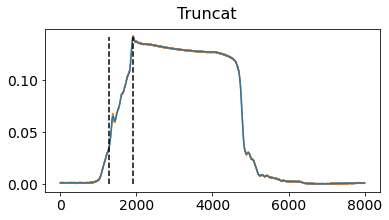


MLSi20HV7kV8mL.5Hz - Trial09 - Seg15
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.143 (bar) in 0.316 (sec)

(8000,)
0.14737808592948978
0.1401038120572807


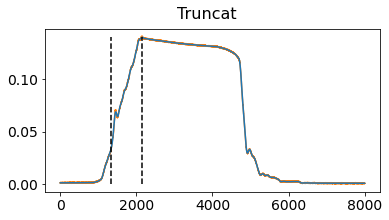


MLSi20HV7kV8mL.5Hz - Trial09 - Seg16
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.141 (bar) in 0.408 (sec)

(8000,)
0.14285541385239456
0.1362833630255647


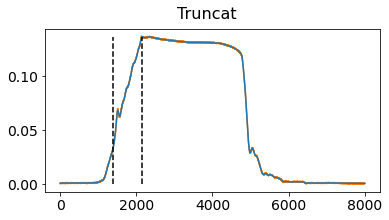


MLSi20HV7kV8mL.5Hz - Trial09 - Seg17
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.137 (bar) in 0.384 (sec)

(8000,)
0.14580637719347797
0.1389476601666011


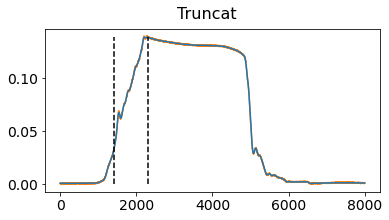


MLSi20HV7kV8mL.5Hz - Trial09 - Seg18
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.140 (bar) in 0.441 (sec)

MLSi20HV7kV8mL.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.15196490938356505
0.1488370849575941


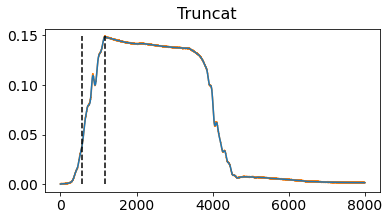


MLSi20HV7kV8mL.5Hz - Trial10 - Seg1
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.149 (bar) in 0.306 (sec)

(8000,)
0.1554771972732241
0.1517956651850451


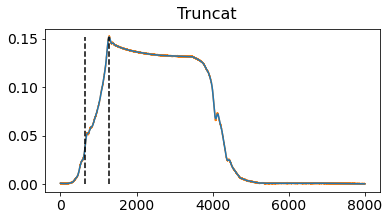


MLSi20HV7kV8mL.5Hz - Trial10 - Seg2
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.153 (bar) in 0.317 (sec)

(8000,)
0.15271868806308092
0.1495240204388349


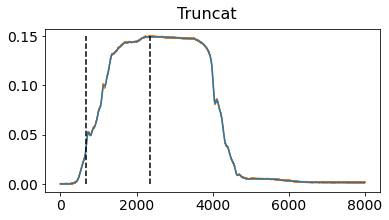


MLSi20HV7kV8mL.5Hz - Trial10 - Seg3
Avg. Pressure of zipping = 0.118 (bar), Max. P. = 0.150 (bar) in 0.846 (sec)

(8000,)
0.11219105565591923
0.10876496853500879


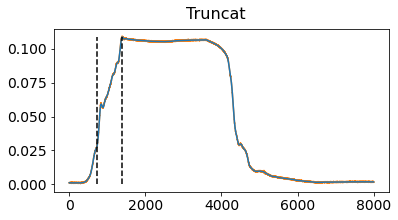


MLSi20HV7kV8mL.5Hz - Trial10 - Seg4
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.109 (bar) in 0.337 (sec)

(8000,)
0.11297691002392514
0.10978092221267982


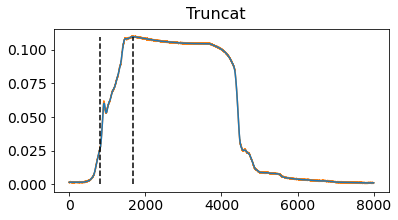


MLSi20HV7kV8mL.5Hz - Trial10 - Seg5
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.110 (bar) in 0.425 (sec)

(8000,)
0.1147571107351222
0.11132741835161086


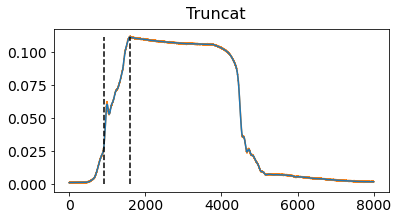


MLSi20HV7kV8mL.5Hz - Trial10 - Seg6
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.112 (bar) in 0.344 (sec)

(8000,)
0.11212690427893916
0.10822224676620233


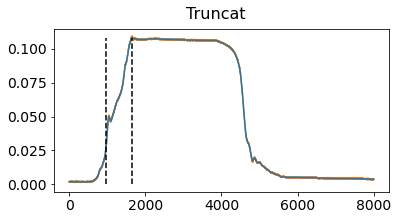


MLSi20HV7kV8mL.5Hz - Trial10 - Seg7
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.109 (bar) in 0.345 (sec)

(8000,)
0.11692221970819969
0.11349803829956784


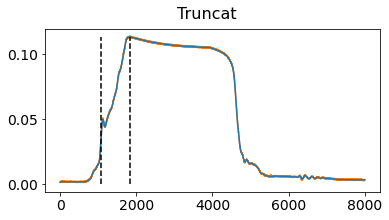


MLSi20HV7kV8mL.5Hz - Trial10 - Seg8
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.114 (bar) in 0.389 (sec)

(8000,)
0.11977695598381298
0.11651759023175208


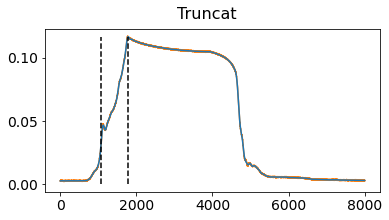


MLSi20HV7kV8mL.5Hz - Trial10 - Seg9
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.117 (bar) in 0.359 (sec)

(8000,)
0.12243923812848605
0.11891191241216531


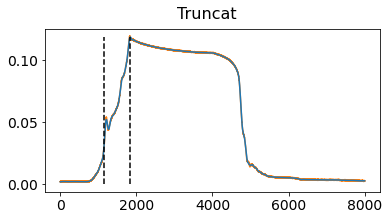


MLSi20HV7kV8mL.5Hz - Trial10 - Seg10
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.120 (bar) in 0.345 (sec)

(8000,)
0.12301660052130671
0.11964009420750175


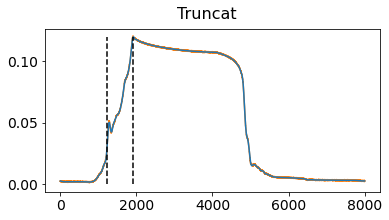


MLSi20HV7kV8mL.5Hz - Trial10 - Seg11
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.120 (bar) in 0.347 (sec)

(8000,)
0.12311282758677682
0.11949538722044828


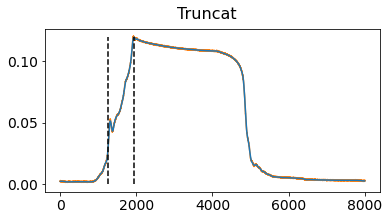


MLSi20HV7kV8mL.5Hz - Trial10 - Seg12
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.120 (bar) in 0.341 (sec)

(8000,)
0.12348169800441225
0.12041569494919553


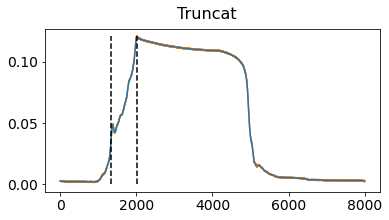


MLSi20HV7kV8mL.5Hz - Trial10 - Seg13
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.121 (bar) in 0.351 (sec)

(8000,)
0.12516567165013917
0.12156031022901871


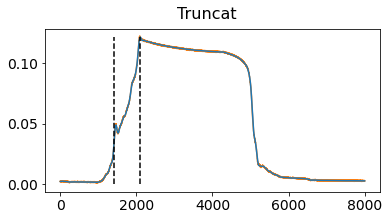


MLSi20HV7kV8mL.5Hz - Trial10 - Seg14
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.122 (bar) in 0.348 (sec)

(8000,)
0.12548642853503955
0.12188322303396174


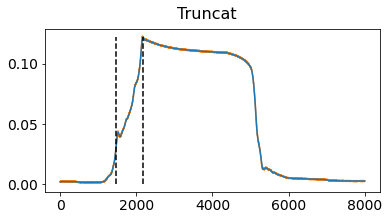


MLSi20HV7kV8mL.5Hz - Trial10 - Seg15
Avg. Pressure of zipping = 0.066 (bar), Max. P. = 0.123 (bar) in 0.355 (sec)

(8000,)
0.12540623931381445
0.12222466109079488


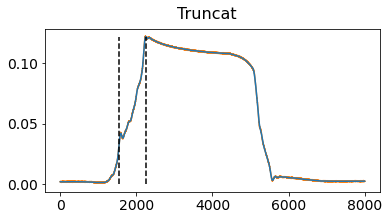


MLSi20HV7kV8mL.5Hz - Trial10 - Seg16
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.123 (bar) in 0.355 (sec)

(8000,)
0.1263845478127606
0.1221339038120139


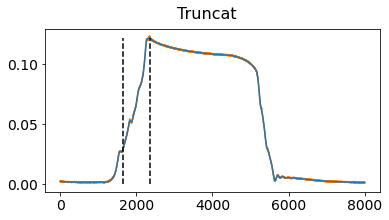


MLSi20HV7kV8mL.5Hz - Trial10 - Seg17
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.124 (bar) in 0.346 (sec)

(8000,)
0.11400333205560632
0.10897565588845479


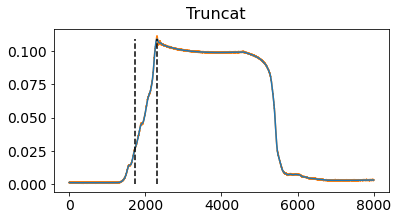


MLSi20HV7kV8mL.5Hz - Trial10 - Seg18
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.111 (bar) in 0.286 (sec)

MLSi20HV7kV10mL.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.15153188758894956
0.13741221397168685


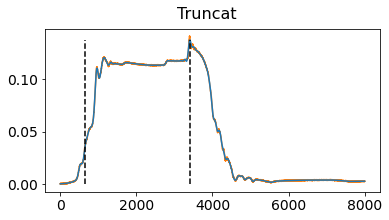


MLSi20HV7kV10mL.5Hz - Trial11 - Seg1
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.141 (bar) in 1.379 (sec)

(8000,)
0.14195729457467351
0.12579857554261986


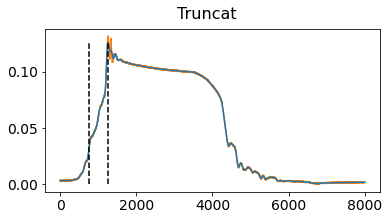


MLSi20HV7kV10mL.5Hz - Trial11 - Seg2
Avg. Pressure of zipping = 0.065 (bar), Max. P. = 0.131 (bar) in 0.251 (sec)

(8000,)
0.13772330369398866
0.1251982536560186


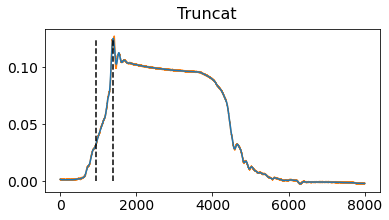


MLSi20HV7kV10mL.5Hz - Trial11 - Seg3
Avg. Pressure of zipping = 0.063 (bar), Max. P. = 0.127 (bar) in 0.230 (sec)

(8000,)
0.12385056842204767
0.10419361960684018


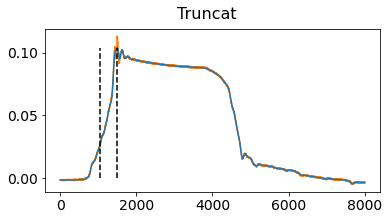


MLSi20HV7kV10mL.5Hz - Trial11 - Seg4
Avg. Pressure of zipping = 0.059 (bar), Max. P. = 0.113 (bar) in 0.227 (sec)

(8000,)
0.10106079174987642
0.08285096639953977


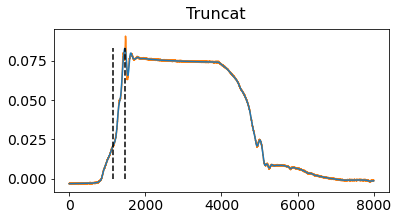


MLSi20HV7kV10mL.5Hz - Trial11 - Seg5
Avg. Pressure of zipping = 0.047 (bar), Max. P. = 0.091 (bar) in 0.154 (sec)

(8000,)
0.10045135366856571
0.07927132033668174


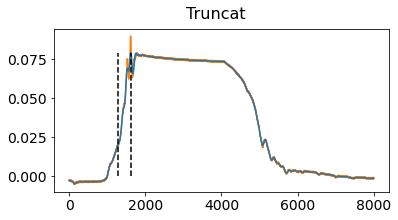


MLSi20HV7kV10mL.5Hz - Trial11 - Seg6
Avg. Pressure of zipping = 0.048 (bar), Max. P. = 0.090 (bar) in 0.171 (sec)

(8000,)
0.09851077451491848
0.08006161957841967


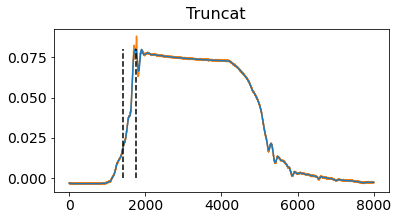


MLSi20HV7kV10mL.5Hz - Trial11 - Seg7
Avg. Pressure of zipping = 0.045 (bar), Max. P. = 0.088 (bar) in 0.159 (sec)

(8000,)
0.09628151416486092
0.07838866334263327


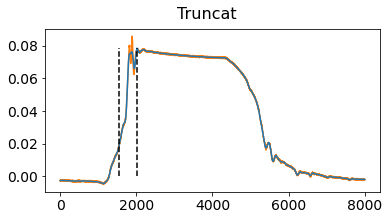


MLSi20HV7kV10mL.5Hz - Trial11 - Seg8
Avg. Pressure of zipping = 0.054 (bar), Max. P. = 0.086 (bar) in 0.234 (sec)

(8000,)
0.08685126174879004
0.07586268728493689


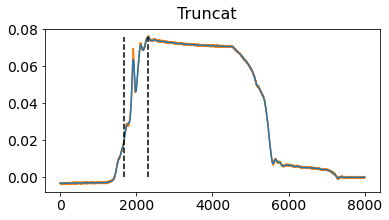


MLSi20HV7kV10mL.5Hz - Trial11 - Seg9
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.076 (bar) in 0.320 (sec)

(8000,)
0.08669088330633987
0.07583023278281044


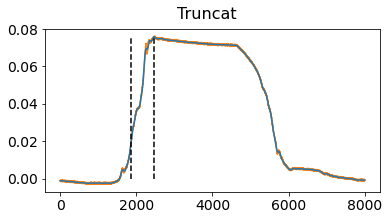


MLSi20HV7kV10mL.5Hz - Trial11 - Seg10
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.076 (bar) in 0.304 (sec)

(8000,)
0.08608144522502915
0.07504774419594235


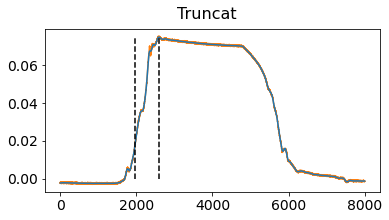


MLSi20HV7kV10mL.5Hz - Trial11 - Seg11
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.076 (bar) in 0.310 (sec)

(8000,)
0.08635408857719447
0.07538397132864598


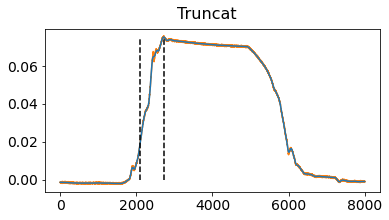


MLSi20HV7kV10mL.5Hz - Trial11 - Seg12
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.076 (bar) in 0.311 (sec)

(8000,)
0.08576068834012879
0.0748296739876458


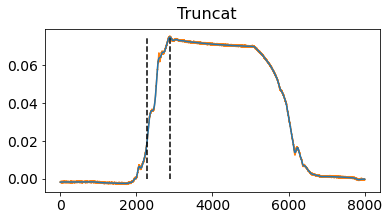


MLSi20HV7kV10mL.5Hz - Trial11 - Seg13
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.075 (bar) in 0.301 (sec)

(8000,)
0.08592106678257898
0.0749011316194735


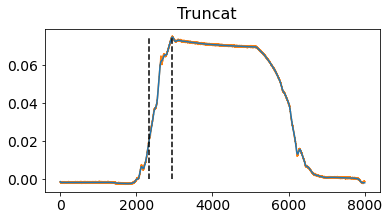


MLSi20HV7kV10mL.5Hz - Trial11 - Seg14
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.075 (bar) in 0.312 (sec)

(8000,)
0.08494275828363285
0.0741155822842804


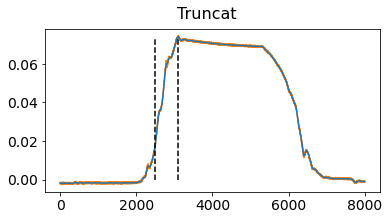


MLSi20HV7kV10mL.5Hz - Trial11 - Seg15
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.074 (bar) in 0.297 (sec)

(8000,)
0.08519936379155314
0.07412911313865729


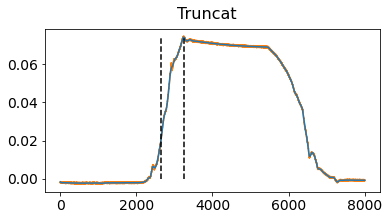


MLSi20HV7kV10mL.5Hz - Trial11 - Seg16
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.075 (bar) in 0.304 (sec)

(8000,)
0.08433332020232215
0.07331850352612779


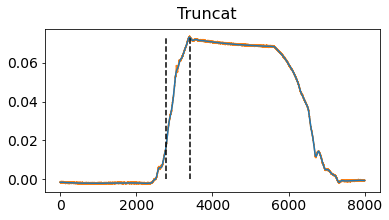


MLSi20HV7kV10mL.5Hz - Trial11 - Seg17
Avg. Pressure of zipping = 0.053 (bar), Max. P. = 0.074 (bar) in 0.302 (sec)

(8000,)
0.08462200139873248
0.07373879640739144


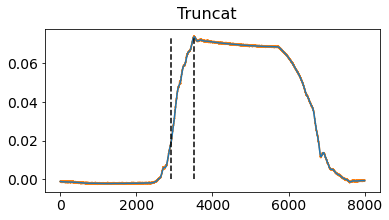


MLSi20HV7kV10mL.5Hz - Trial11 - Seg18
Avg. Pressure of zipping = 0.052 (bar), Max. P. = 0.074 (bar) in 0.306 (sec)

MLSi20HV7kV10mL.5Hz
Signal frequency (Hz) = 0.500
(8000,)
0.16455461711590455
0.13503948194527587


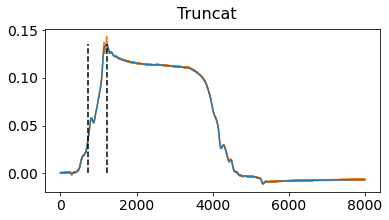


MLSi20HV7kV10mL.5Hz - Trial12 - Seg1
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.144 (bar) in 0.250 (sec)

(8000,)
0.15182056878535988
0.1266888634778085


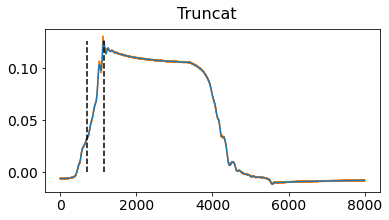


MLSi20HV7kV10mL.5Hz - Trial12 - Seg2
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.131 (bar) in 0.224 (sec)

(8000,)
0.1385572715947296
0.11627137144300011


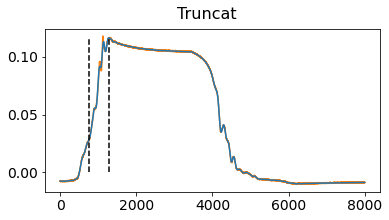


MLSi20HV7kV10mL.5Hz - Trial12 - Seg3
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.118 (bar) in 0.254 (sec)

(8000,)
0.1395836936264108
0.11801709854375624


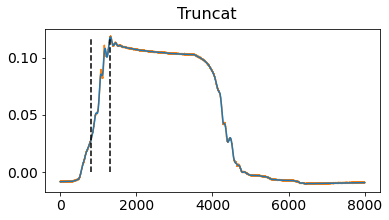


MLSi20HV7kV10mL.5Hz - Trial12 - Seg4
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.119 (bar) in 0.251 (sec)

(8000,)
0.13797990920190895
0.11598594879454303


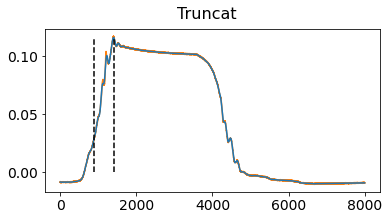


MLSi20HV7kV10mL.5Hz - Trial12 - Seg5
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.117 (bar) in 0.254 (sec)

(8000,)
0.13746669818606835
0.11539252091187994


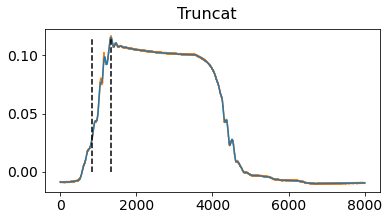


MLSi20HV7kV10mL.5Hz - Trial12 - Seg6
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.117 (bar) in 0.247 (sec)

(8000,)
0.1358468759173215
0.1140065294893677


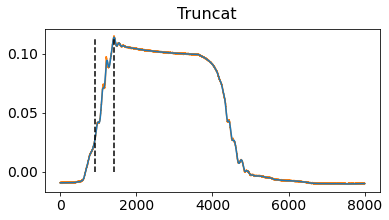


MLSi20HV7kV10mL.5Hz - Trial12 - Seg7
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.115 (bar) in 0.249 (sec)

(8000,)
0.1348044160413953
0.11264731489352013


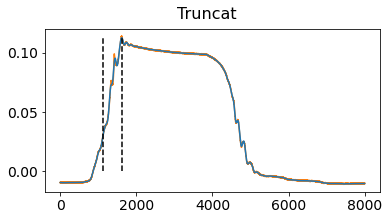


MLSi20HV7kV10mL.5Hz - Trial12 - Seg8
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.114 (bar) in 0.251 (sec)

(8000,)
0.13279968551076798
0.11106513516147544


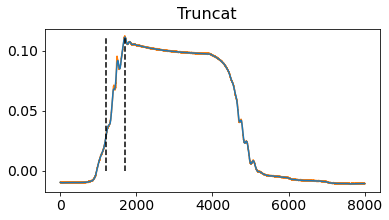


MLSi20HV7kV10mL.5Hz - Trial12 - Seg9
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.112 (bar) in 0.251 (sec)

(8000,)
0.1309072198898558
0.10912274383366698


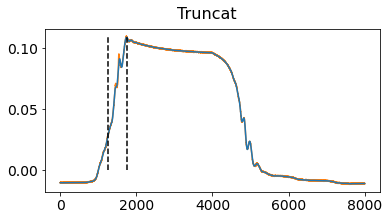


MLSi20HV7kV10mL.5Hz - Trial12 - Seg10
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.110 (bar) in 0.249 (sec)

(8000,)
0.12883833798224842
0.10752347496461122


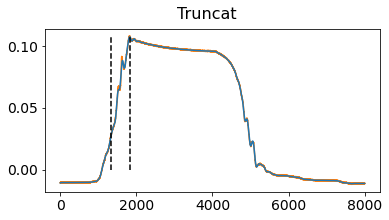


MLSi20HV7kV10mL.5Hz - Trial12 - Seg11
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.108 (bar) in 0.247 (sec)

(8000,)
0.12826097558942776
0.10683102765296475


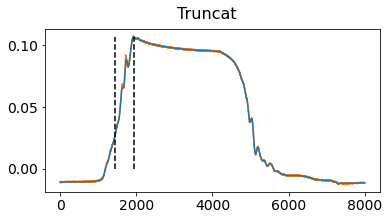


MLSi20HV7kV10mL.5Hz - Trial12 - Seg12
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.107 (bar) in 0.245 (sec)

(8000,)
0.12704209942680636
0.10579343427382328


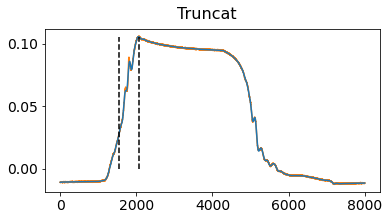


MLSi20HV7kV10mL.5Hz - Trial12 - Seg13
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.106 (bar) in 0.259 (sec)

(8000,)
0.12643266134549563
0.10496158106133364


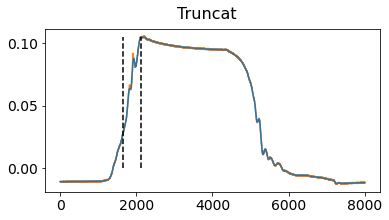


MLSi20HV7kV10mL.5Hz - Trial12 - Seg14
Avg. Pressure of zipping = 0.070 (bar), Max. P. = 0.106 (bar) in 0.247 (sec)

(8000,)
0.1264807748782307
0.10534944802143996


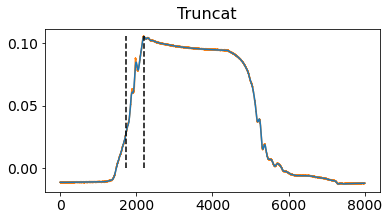


MLSi20HV7kV10mL.5Hz - Trial12 - Seg15
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.106 (bar) in 0.241 (sec)

(8000,)
0.12652888841096577
0.1048786005063106


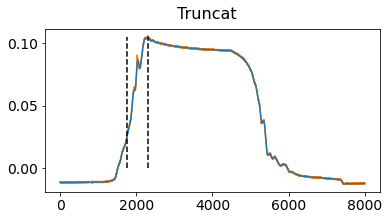


MLSi20HV7kV10mL.5Hz - Trial12 - Seg16
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.106 (bar) in 0.272 (sec)

(8000,)
0.1259675638623901
0.10457678690718612


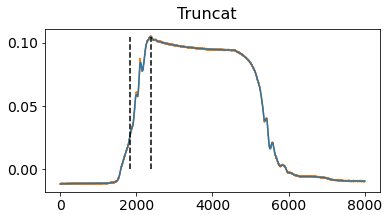


MLSi20HV7kV10mL.5Hz - Trial12 - Seg17
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.105 (bar) in 0.273 (sec)

(8000,)
0.12601567739512518
0.10466392830723915


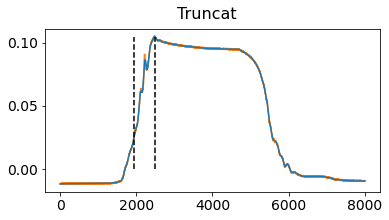


MLSi20HV7kV10mL.5Hz - Trial12 - Seg18
Avg. Pressure of zipping = 0.071 (bar), Max. P. = 0.105 (bar) in 0.267 (sec)



In [5]:
'''Measurement 2022 Twenty Trial (Act4 Act6, with frequency of 0.5Hz, 1Hz)'''
'''
Shifted0.5s: 1-3, 5-7, 9-11, ...
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77]
'''

pressData = []
Fs = 2000

# measureDataPath = ".\Data220401Relabelled\ValidData"
measureDataPath = ".\Data220401Relabelled\Act6Volume"

for root, directories, files in walk(measureDataPath):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
#                 ax, _ = aPlot()
#                 ax.plot(data)
#                 ax.plot(beginInd, np.zeros(beginInd.shape), '*r')
#                 ax.plot(endInd, np.zeros(endInd.shape), '*g')
#                 plt.show()

                for i in range(len(beginInd)): 
#                     ax.plot(beginInd[i]+np.arange(len(data[beginInd[i]:endInd[i]])), data[beginInd[i]:endInd[i]])
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, 
                                                                               inactivePressure, 20, 8)
                    P0 = data[beginInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")

MLSi20HV7kV10mL.5Hz
Signal frequency (Hz) = 0.500
(164000,)
max value of raw data = 0.167
0.14486693691590977
[  8545  17505  26480  35434  44412  53314  62328  71322  80242  89212
  98208 107200 116160 125039 134081 143122 152010]
[ 13895  22848  31815  40782  49718  58650  67696  76694  85576  94587
 103586 112526 121471 130428 139439 148419 157401]
Avg. segment length = 8967
(8968,)
0.13858934728321964
0.12737545810651263


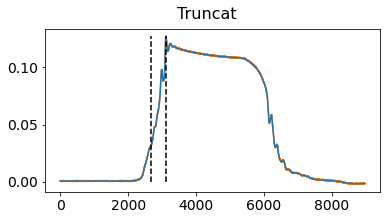


MLSi20HV7kV10mL.5Hz - Trial13 - Seg1
Avg. Pressure of zipping = 0.069 (bar), Max. P. = 0.127 (bar) in 0.214 (sec)

(8956,)
0.12676945607464105
0.1153212115246584


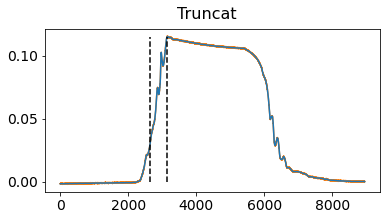


MLSi20HV7kV10mL.5Hz - Trial13 - Seg2
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.116 (bar) in 0.257 (sec)

(8971,)
0.12633643428002553
0.11482960873640563


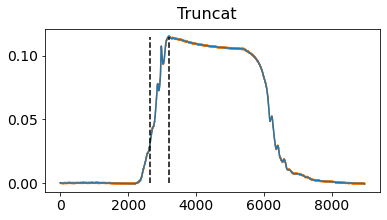


MLSi20HV7kV10mL.5Hz - Trial13 - Seg3
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.115 (bar) in 0.291 (sec)

(8961,)
0.12697794804982626
0.1155118255291952


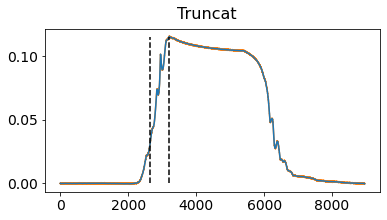


MLSi20HV7kV10mL.5Hz - Trial13 - Seg4
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.116 (bar) in 0.291 (sec)

(8957,)
0.12635247212427056
0.11483993878025586


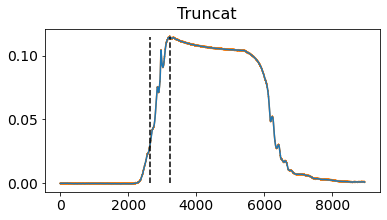


MLSi20HV7kV10mL.5Hz - Trial13 - Seg5
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.115 (bar) in 0.295 (sec)

(8917,)
0.13302421533019823
0.12164991476941242


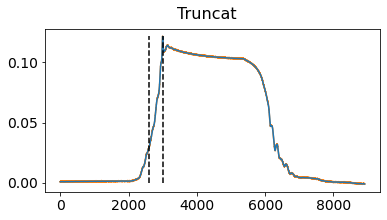


MLSi20HV7kV10mL.5Hz - Trial13 - Seg6
Avg. Pressure of zipping = 0.064 (bar), Max. P. = 0.122 (bar) in 0.194 (sec)

(9030,)
0.1279562565487724
0.11658123531232437


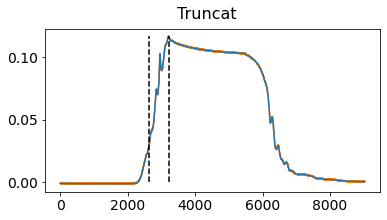


MLSi20HV7kV10mL.5Hz - Trial13 - Seg7
Avg. Pressure of zipping = 0.078 (bar), Max. P. = 0.117 (bar) in 0.289 (sec)

(8996,)
0.12564680697748973
0.11428243205719774


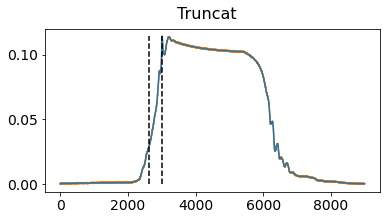


MLSi20HV7kV10mL.5Hz - Trial13 - Seg8
Avg. Pressure of zipping = 0.060 (bar), Max. P. = 0.115 (bar) in 0.198 (sec)

(8901,)
0.12591945032965504
0.11454628602879224


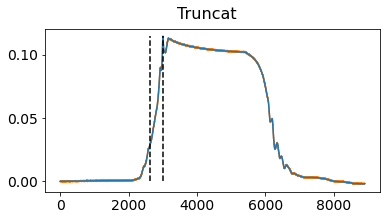


MLSi20HV7kV10mL.5Hz - Trial13 - Seg9
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.115 (bar) in 0.190 (sec)

(8990,)
0.1270741751152964
0.11571278059874274


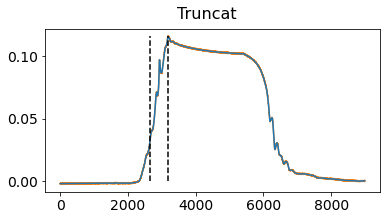


MLSi20HV7kV10mL.5Hz - Trial13 - Seg10
Avg. Pressure of zipping = 0.076 (bar), Max. P. = 0.116 (bar) in 0.275 (sec)

(8998,)
0.12587133679692
0.11463648963178738


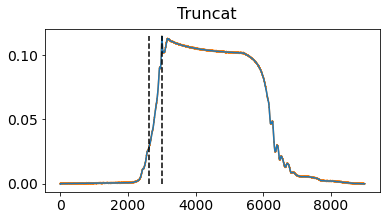


MLSi20HV7kV10mL.5Hz - Trial13 - Seg11
Avg. Pressure of zipping = 0.061 (bar), Max. P. = 0.115 (bar) in 0.188 (sec)

(8966,)
0.16652727195804184
0.1553112592458571


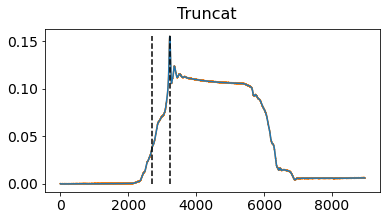


MLSi20HV7kV10mL.5Hz - Trial13 - Seg12
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.155 (bar) in 0.258 (sec)

(8952,)
0.15247812039940564
0.14099587952309323


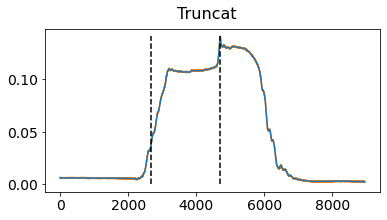


MLSi20HV7kV10mL.5Hz - Trial13 - Seg13
Avg. Pressure of zipping = 0.101 (bar), Max. P. = 0.141 (bar) in 1.022 (sec)

(8918,)
0.15558946218293923
0.1441234524409565


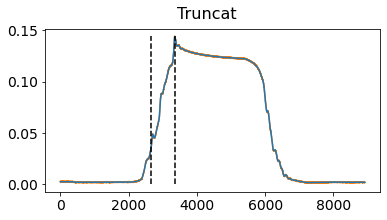


MLSi20HV7kV10mL.5Hz - Trial13 - Seg14
Avg. Pressure of zipping = 0.086 (bar), Max. P. = 0.144 (bar) in 0.345 (sec)

(9027,)
0.15828382001610233
0.14680663175646566


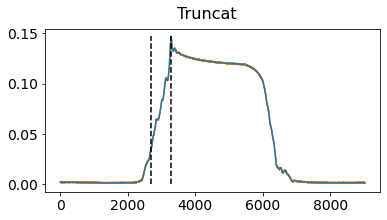


MLSi20HV7kV10mL.5Hz - Trial13 - Seg15
Avg. Pressure of zipping = 0.082 (bar), Max. P. = 0.147 (bar) in 0.291 (sec)

(9010,)
0.1559102190678396
0.14463972403268488


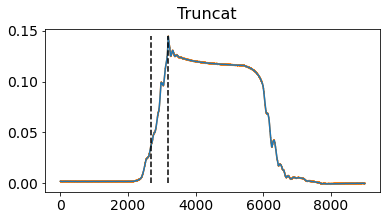


MLSi20HV7kV10mL.5Hz - Trial13 - Seg16
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.145 (bar) in 0.259 (sec)

(8935,)
0.16017628563701453
0.14865654057763536


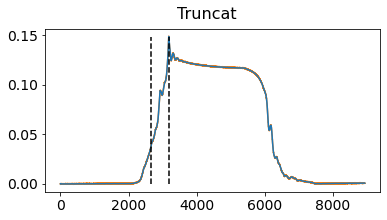


MLSi20HV7kV10mL.5Hz - Trial13 - Seg17
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.149 (bar) in 0.263 (sec)

MLSi20HV7kV10mL1Hz
Signal frequency (Hz) = 1.000
(82000,)
max value of raw data = 0.175
0.16556349861315117
[ 5296  9788 14218 18699 23190 27662 32136 36535 41026 45483 49958 54435
 58912 63382 67797 72284 76760]
[ 7934 12419 16897 21387 25847 30321 34786 39202 43678 48165 52643 57091
 61608 66076 70465 74934 79409]
Avg. segment length = 4466
(4467,)
0.1748188374327164
0.16644387608595723


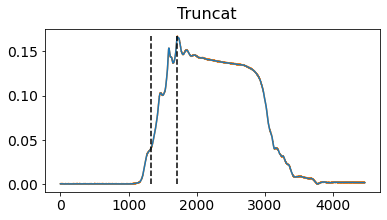


MLSi20HV7kV10mL1Hz - Trial14 - Seg1
Avg. Pressure of zipping = 0.108 (bar), Max. P. = 0.167 (bar) in 0.190 (sec)

(4488,)
0.16019232348125953
0.15180289148564868


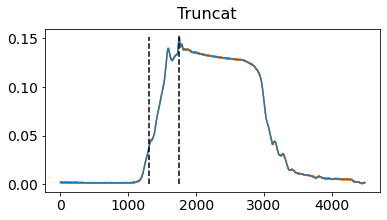


MLSi20HV7kV10mL1Hz - Trial14 - Seg2
Avg. Pressure of zipping = 0.099 (bar), Max. P. = 0.152 (bar) in 0.223 (sec)

(4454,)
0.1600800585715444
0.15186919100118046


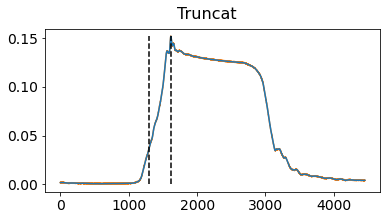


MLSi20HV7kV10mL1Hz - Trial14 - Seg3
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.152 (bar) in 0.158 (sec)

(4486,)
0.15728947367291118
0.1490547890199091


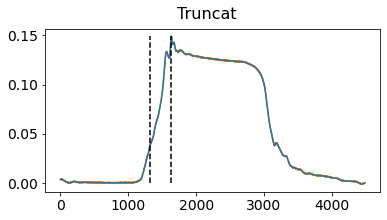


MLSi20HV7kV10mL1Hz - Trial14 - Seg4
Avg. Pressure of zipping = 0.088 (bar), Max. P. = 0.149 (bar) in 0.159 (sec)

(4475,)
0.13616763280222186
0.1279254978722349


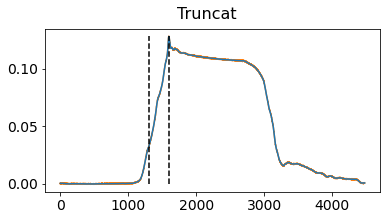


MLSi20HV7kV10mL1Hz - Trial14 - Seg5
Avg. Pressure of zipping = 0.075 (bar), Max. P. = 0.128 (bar) in 0.147 (sec)

(4473,)
0.13422705364857462
0.12613615226017066


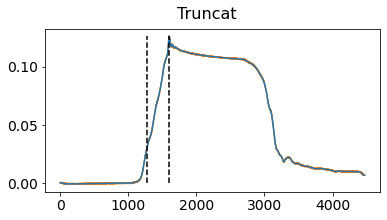


MLSi20HV7kV10mL1Hz - Trial14 - Seg6
Avg. Pressure of zipping = 0.074 (bar), Max. P. = 0.126 (bar) in 0.161 (sec)

(4470,)
0.16679991531020716
0.15849945882327277


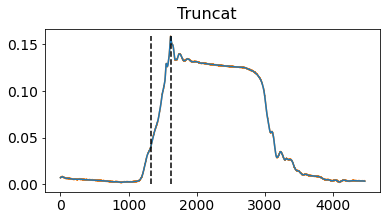


MLSi20HV7kV10mL1Hz - Trial14 - Seg7
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.159 (bar) in 0.147 (sec)

(4407,)
0.15531681883077392
0.14722828868602802


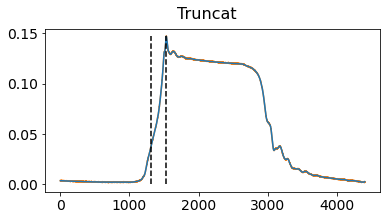


MLSi20HV7kV10mL1Hz - Trial14 - Seg8
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.147 (bar) in 0.113 (sec)

(4484,)
0.1445554253423665
0.13639327044616395


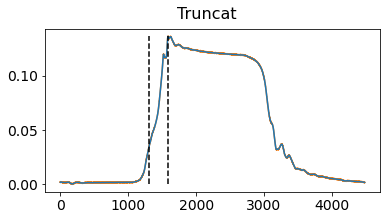


MLSi20HV7kV10mL1Hz - Trial14 - Seg9
Avg. Pressure of zipping = 0.079 (bar), Max. P. = 0.137 (bar) in 0.141 (sec)

(4472,)
0.1390544447663252
0.13081002050930396


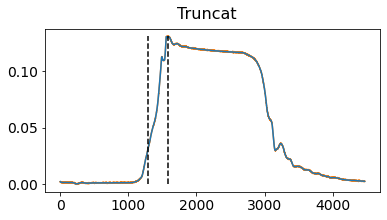


MLSi20HV7kV10mL1Hz - Trial14 - Seg10
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.131 (bar) in 0.144 (sec)

(4476,)
0.15796306313120195
0.14992401376655648


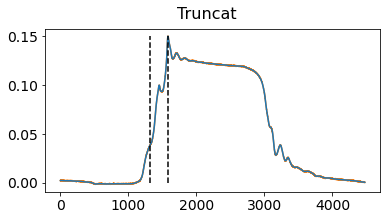


MLSi20HV7kV10mL1Hz - Trial14 - Seg11
Avg. Pressure of zipping = 0.084 (bar), Max. P. = 0.150 (bar) in 0.136 (sec)

(4463,)
0.1385412337504846
0.13072083547447436


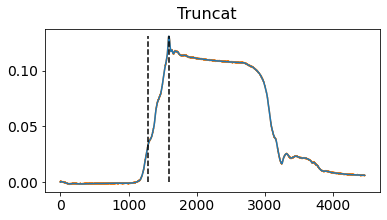


MLSi20HV7kV10mL1Hz - Trial14 - Seg12
Avg. Pressure of zipping = 0.073 (bar), Max. P. = 0.131 (bar) in 0.153 (sec)

(4497,)
0.15730551151715622
0.14891360310927582


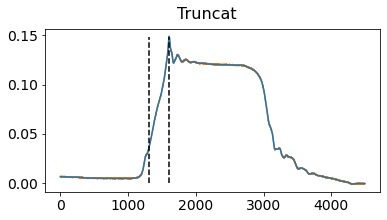


MLSi20HV7kV10mL1Hz - Trial14 - Seg13
Avg. Pressure of zipping = 0.085 (bar), Max. P. = 0.149 (bar) in 0.147 (sec)

(4469,)
0.15255830962063074
0.1442340497790691


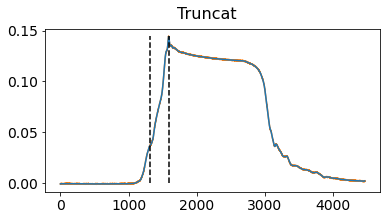


MLSi20HV7kV10mL1Hz - Trial14 - Seg14
Avg. Pressure of zipping = 0.080 (bar), Max. P. = 0.145 (bar) in 0.140 (sec)

(4402,)
0.13571857316336133
0.12754095489832878


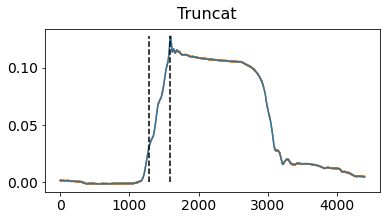


MLSi20HV7kV10mL1Hz - Trial14 - Seg15
Avg. Pressure of zipping = 0.072 (bar), Max. P. = 0.128 (bar) in 0.153 (sec)

(4478,)
0.13292798826472813
0.1249619773027382


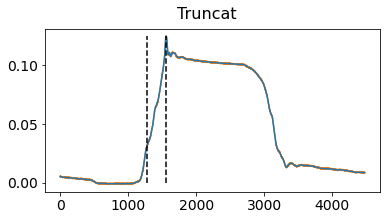


MLSi20HV7kV10mL1Hz - Trial14 - Seg16
Avg. Pressure of zipping = 0.068 (bar), Max. P. = 0.125 (bar) in 0.140 (sec)

(4475,)
0.1598234530636241
0.1513702392740273


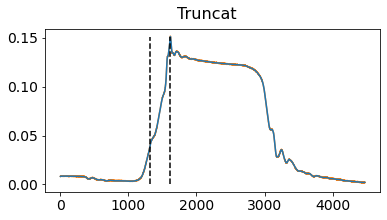


MLSi20HV7kV10mL1Hz - Trial14 - Seg17
Avg. Pressure of zipping = 0.081 (bar), Max. P. = 0.152 (bar) in 0.152 (sec)

MLSi20HV7kV10mL2Hz
Signal frequency (Hz) = 2.000
(41000,)
max value of raw data = 0.181
0.16336610292411913
[ 3655  5908  8169 10434 12688 14953 17203 19455 21720 23973 26220 28424
 30682 32937 35187 37440]
[ 4999  7256  9507 11774 14033 16286 18539 20793 23056 25307 27503 29757
 32019 34273 36525 38771]
Avg. segment length = 2251
(2252,)
0.1811698237537437
0.17313791261490777


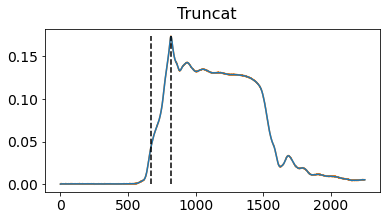


MLSi20HV7kV10mL2Hz - Trial16 - Seg1
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.174 (bar) in 0.074 (sec)

(2255,)
0.1564394679279252
0.14835949986426095


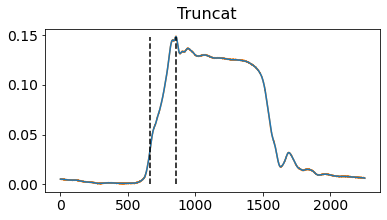


MLSi20HV7kV10mL2Hz - Trial16 - Seg2
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.149 (bar) in 0.095 (sec)

(2256,)
0.15283095297279606
0.14524146767875365


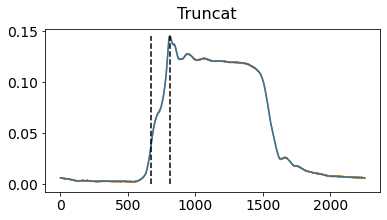


MLSi20HV7kV10mL2Hz - Trial16 - Seg3
Avg. Pressure of zipping = 0.083 (bar), Max. P. = 0.145 (bar) in 0.070 (sec)

(2266,)
0.17470657252300126
0.16698330918277376


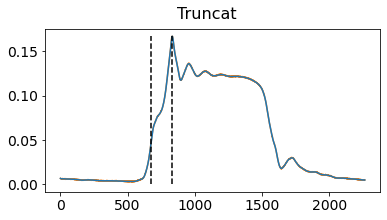


MLSi20HV7kV10mL2Hz - Trial16 - Seg4
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.167 (bar) in 0.081 (sec)

(2256,)
0.15647154361641524
0.1483392492521264


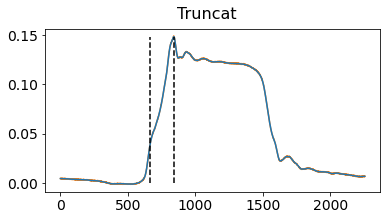


MLSi20HV7kV10mL2Hz - Trial16 - Seg5
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.149 (bar) in 0.089 (sec)

(2259,)
0.13650442753136724
0.12863137451309545


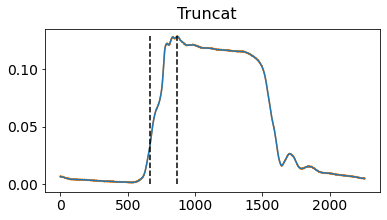


MLSi20HV7kV10mL2Hz - Trial16 - Seg6
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.129 (bar) in 0.102 (sec)

(2252,)
0.14099502391997243
0.1330734732562363


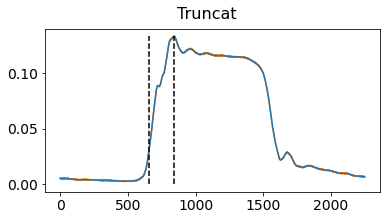


MLSi20HV7kV10mL2Hz - Trial16 - Seg7
Avg. Pressure of zipping = 0.095 (bar), Max. P. = 0.133 (bar) in 0.091 (sec)

(2253,)
0.14261484618871928
0.13466230738647275


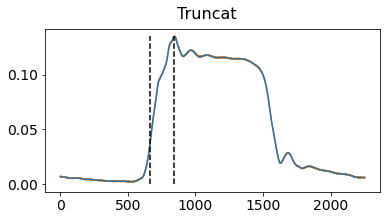


MLSi20HV7kV10mL2Hz - Trial16 - Seg8
Avg. Pressure of zipping = 0.097 (bar), Max. P. = 0.135 (bar) in 0.092 (sec)

(2264,)
0.16923766763544995
0.16156477237157352


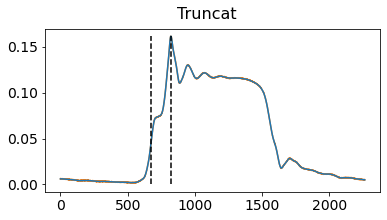


MLSi20HV7kV10mL2Hz - Trial16 - Seg9
Avg. Pressure of zipping = 0.089 (bar), Max. P. = 0.162 (bar) in 0.076 (sec)

(2252,)
0.14203748379589862
0.1340411526178688


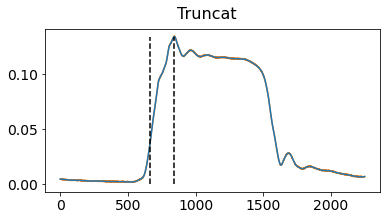


MLSi20HV7kV10mL2Hz - Trial16 - Seg10
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.134 (bar) in 0.092 (sec)

(2221,)
0.14104313745270747
0.13299166554010255


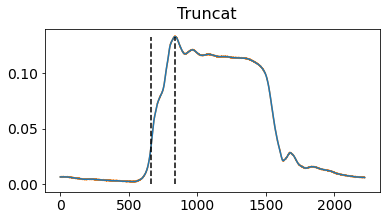


MLSi20HV7kV10mL2Hz - Trial16 - Seg11
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.133 (bar) in 0.088 (sec)

(2229,)
0.1405620021253569
0.13251935344306345


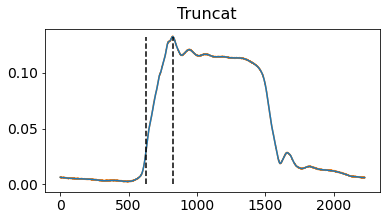


MLSi20HV7kV10mL2Hz - Trial16 - Seg12
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.133 (bar) in 0.096 (sec)

(2260,)
0.1688367215293245
0.16116910595572828


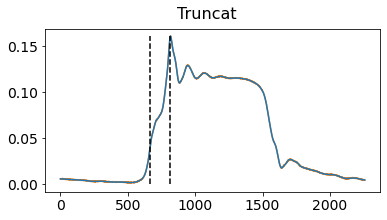


MLSi20HV7kV10mL2Hz - Trial16 - Seg13
Avg. Pressure of zipping = 0.087 (bar), Max. P. = 0.161 (bar) in 0.075 (sec)

(2255,)
0.14009690464225139
0.1321855677793162


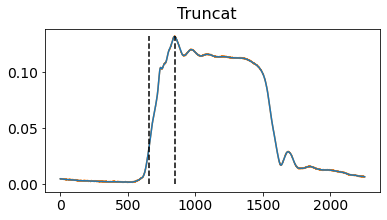


MLSi20HV7kV10mL2Hz - Trial16 - Seg14
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.132 (bar) in 0.094 (sec)

(2251,)
0.16394517903459385
0.15613225117465138


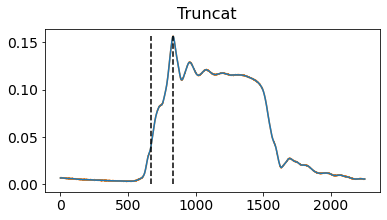


MLSi20HV7kV10mL2Hz - Trial16 - Seg15
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.156 (bar) in 0.083 (sec)

(2249,)
0.13860538512746468
0.1304618745807873


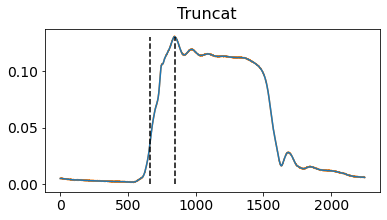


MLSi20HV7kV10mL2Hz - Trial16 - Seg16
Avg. Pressure of zipping = 0.094 (bar), Max. P. = 0.131 (bar) in 0.092 (sec)

MLSi20HV7kV10mL4Hz
Signal frequency (Hz) = 4.000
(20500,)
max value of raw data = 0.188
0.16664044895718405
[ 2826  3957  5088  6221  7353  8485  9613 10741 11870 12996 14119 15248
 16375 17508 18633 19761]
[ 3505  4635  5765  6896  8027  9159 10285 11416 12542 13664 14791 15918
 17046 18176 19300 20431]
Avg. segment length = 1128
(1129,)
0.18800194540212156
0.17988984761267987


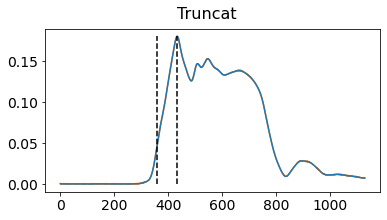


MLSi20HV7kV10mL4Hz - Trial17 - Seg1
Avg. Pressure of zipping = 0.117 (bar), Max. P. = 0.180 (bar) in 0.037 (sec)

(1131,)
0.16829143482499387
0.16015501488747308


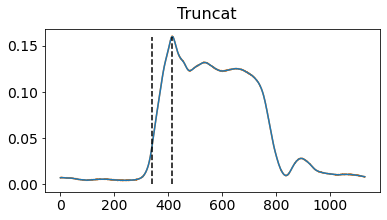


MLSi20HV7kV10mL4Hz - Trial17 - Seg2
Avg. Pressure of zipping = 0.110 (bar), Max. P. = 0.161 (bar) in 0.038 (sec)

(1130,)
0.16169988084029127
0.15387250657442483


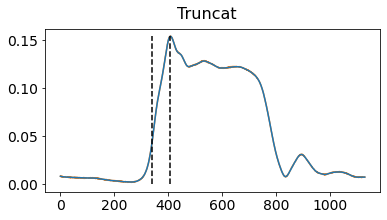


MLSi20HV7kV10mL4Hz - Trial17 - Seg3
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.154 (bar) in 0.035 (sec)

(1132,)
0.16917351625846988
0.1609772611376159


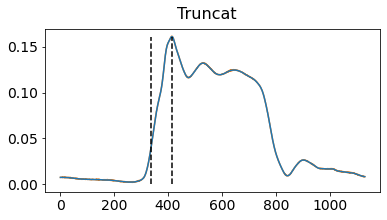


MLSi20HV7kV10mL4Hz - Trial17 - Seg4
Avg. Pressure of zipping = 0.109 (bar), Max. P. = 0.161 (bar) in 0.038 (sec)

(1132,)
0.15568568924840934
0.1477630233798821


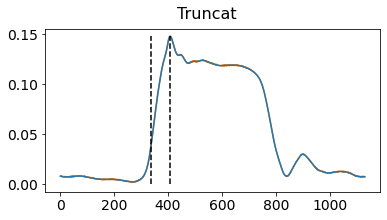


MLSi20HV7kV10mL4Hz - Trial17 - Seg5
Avg. Pressure of zipping = 0.102 (bar), Max. P. = 0.148 (bar) in 0.036 (sec)

(1132,)
0.15159603896592963
0.14374157466771167


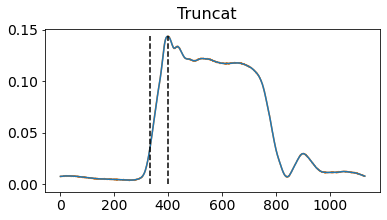


MLSi20HV7kV10mL4Hz - Trial17 - Seg6
Avg. Pressure of zipping = 0.096 (bar), Max. P. = 0.144 (bar) in 0.033 (sec)

(1127,)
0.15032904927057317
0.14266377654398393


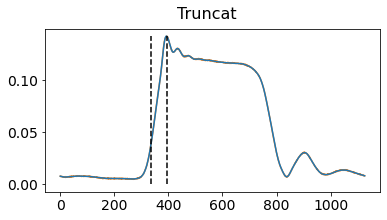


MLSi20HV7kV10mL4Hz - Trial17 - Seg7
Avg. Pressure of zipping = 0.092 (bar), Max. P. = 0.143 (bar) in 0.029 (sec)

(1129,)
0.1398563369785761
0.13192846070931122


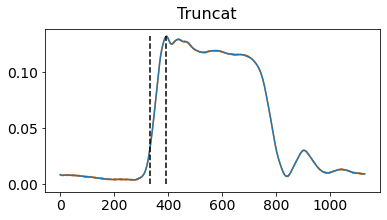


MLSi20HV7kV10mL4Hz - Trial17 - Seg8
Avg. Pressure of zipping = 0.091 (bar), Max. P. = 0.132 (bar) in 0.030 (sec)

(1128,)
0.14229408930381893
0.13422171552617657


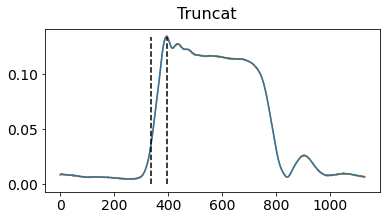


MLSi20HV7kV10mL4Hz - Trial17 - Seg9
Avg. Pressure of zipping = 0.090 (bar), Max. P. = 0.135 (bar) in 0.029 (sec)

(1124,)
0.1496714976565274
0.14184729961360387


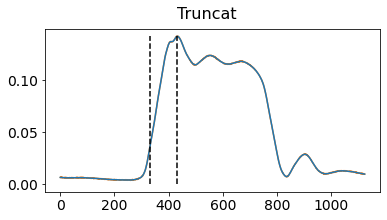


MLSi20HV7kV10mL4Hz - Trial17 - Seg10
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.142 (bar) in 0.051 (sec)

(1125,)
0.14035351015017167
0.13213496111465473


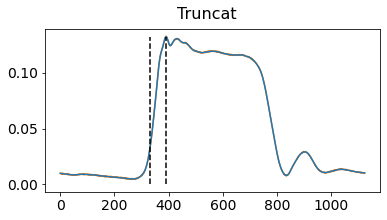


MLSi20HV7kV10mL4Hz - Trial17 - Seg11
Avg. Pressure of zipping = 0.093 (bar), Max. P. = 0.133 (bar) in 0.029 (sec)

(1128,)
0.13935916380698055
0.1312973248105305


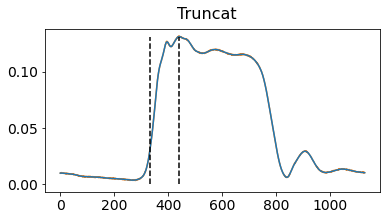


MLSi20HV7kV10mL4Hz - Trial17 - Seg12
Avg. Pressure of zipping = 0.106 (bar), Max. P. = 0.132 (bar) in 0.053 (sec)

(1127,)
0.13783556860370377
0.13001569251318443


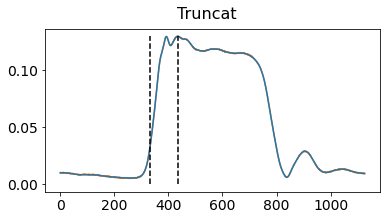


MLSi20HV7kV10mL4Hz - Trial17 - Seg13
Avg. Pressure of zipping = 0.105 (bar), Max. P. = 0.130 (bar) in 0.051 (sec)

(1132,)
0.14069030487931708
0.13249489453570742


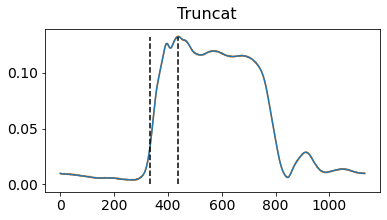


MLSi20HV7kV10mL4Hz - Trial17 - Seg14
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.133 (bar) in 0.053 (sec)

(1124,)
0.13692141148173773
0.12907656008386226


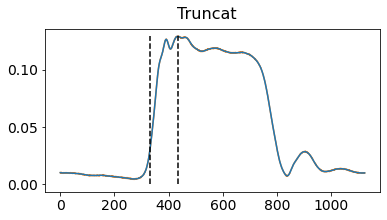


MLSi20HV7kV10mL4Hz - Trial17 - Seg15
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.129 (bar) in 0.051 (sec)

(1130,)
0.13850915806199457
0.13049003522620412


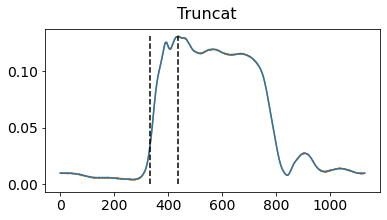


MLSi20HV7kV10mL4Hz - Trial17 - Seg16
Avg. Pressure of zipping = 0.104 (bar), Max. P. = 0.131 (bar) in 0.051 (sec)

MLSi20HV7kV10mL10Hz
Signal frequency (Hz) = 10.000
(8200,)
max value of raw data = 0.199
0.18595847240965774
[2378 2814 3265 3718 4171 4625 5074 5528 5979 6433 6888 7340 7793]
[2634 3085 3537 3988 4438 4886 5338 5791 6245 6701 7154 7604 8059]
Avg. segment length = 451
(452,)
0.19866711182505886
0.19153768713026798


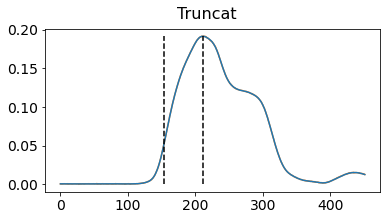


MLSi20HV7kV10mL10Hz - Trial18 - Seg1
Avg. Pressure of zipping = 0.140 (bar), Max. P. = 0.192 (bar) in 0.029 (sec)

(443,)
0.17690375718456877
0.16965008439211718


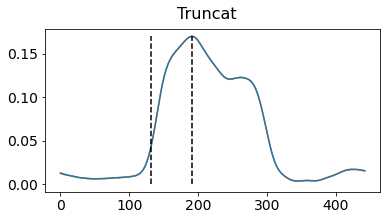


MLSi20HV7kV10mL10Hz - Trial18 - Seg2
Avg. Pressure of zipping = 0.131 (bar), Max. P. = 0.170 (bar) in 0.029 (sec)

(452,)
0.17578110808741748
0.16855631352670164


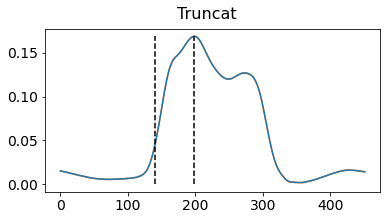


MLSi20HV7kV10mL10Hz - Trial18 - Seg3
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.169 (bar) in 0.029 (sec)

(452,)
0.17642262185721824
0.16943026489077978


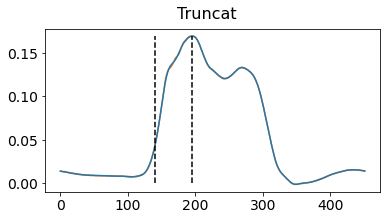


MLSi20HV7kV10mL10Hz - Trial18 - Seg4
Avg. Pressure of zipping = 0.129 (bar), Max. P. = 0.169 (bar) in 0.028 (sec)

(451,)
0.17393675599924036
0.16680800936975573


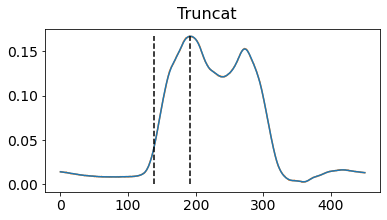


MLSi20HV7kV10mL10Hz - Trial18 - Seg5
Avg. Pressure of zipping = 0.124 (bar), Max. P. = 0.167 (bar) in 0.026 (sec)

(451,)
0.1876972263614662
0.18028279192145596


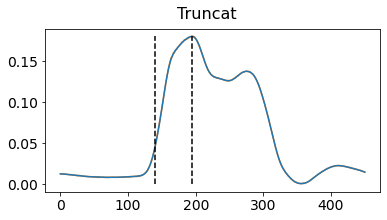


MLSi20HV7kV10mL10Hz - Trial18 - Seg6
Avg. Pressure of zipping = 0.140 (bar), Max. P. = 0.181 (bar) in 0.027 (sec)

(451,)
0.1841207870948271
0.17615686862612606


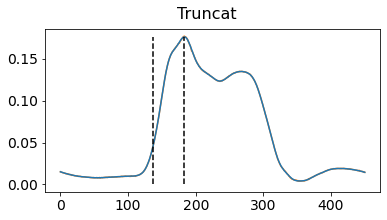


MLSi20HV7kV10mL10Hz - Trial18 - Seg7
Avg. Pressure of zipping = 0.130 (bar), Max. P. = 0.177 (bar) in 0.023 (sec)

(453,)
0.17983868268140715
0.1719907627224168


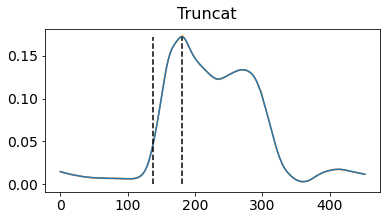


MLSi20HV7kV10mL10Hz - Trial18 - Seg8
Avg. Pressure of zipping = 0.126 (bar), Max. P. = 0.173 (bar) in 0.021 (sec)

(453,)
0.17521978353884185
0.16767608922682947


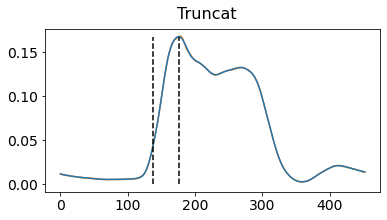


MLSi20HV7kV10mL10Hz - Trial18 - Seg9
Avg. Pressure of zipping = 0.122 (bar), Max. P. = 0.168 (bar) in 0.019 (sec)

(455,)
0.1763103569475031
0.16829931605735893


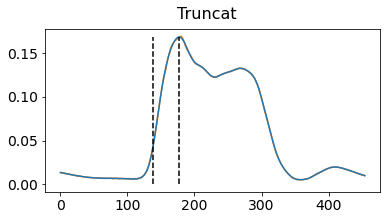


MLSi20HV7kV10mL10Hz - Trial18 - Seg10
Avg. Pressure of zipping = 0.123 (bar), Max. P. = 0.169 (bar) in 0.019 (sec)

(454,)
0.1671206721951075
0.1588786108021399


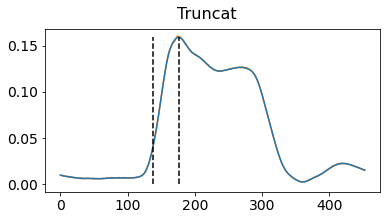


MLSi20HV7kV10mL10Hz - Trial18 - Seg11
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.160 (bar) in 0.019 (sec)

(451,)
0.17141881445277246
0.16251759693385842


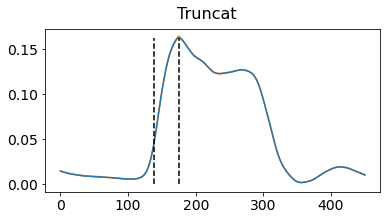


MLSi20HV7kV10mL10Hz - Trial18 - Seg12
Avg. Pressure of zipping = 0.119 (bar), Max. P. = 0.164 (bar) in 0.018 (sec)

(454,)
0.17592544868562265
0.16648918860574927


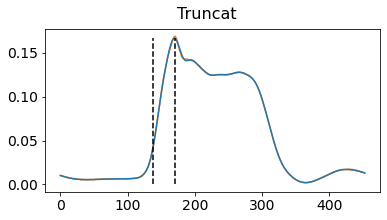


MLSi20HV7kV10mL10Hz - Trial18 - Seg13
Avg. Pressure of zipping = 0.116 (bar), Max. P. = 0.169 (bar) in 0.016 (sec)

MLSi20HV7kV10mL20Hz
Signal frequency (Hz) = 20.000
(4100,)
max value of raw data = 0.204
0.17962349429732835
[2195 2408 2627 2833 3055 3272 3505 3726]
[2323 2540 2743 2967 3190 3414 3634 3858]
Avg. segment length = 219
(219,)
0.20441836274700548
0.18386939887722611


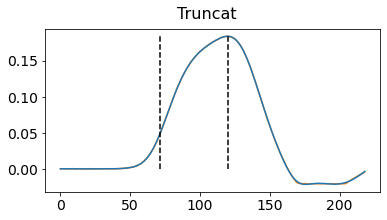


MLSi20HV7kV10mL20Hz - Trial19 - Seg1
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.184 (bar) in 0.025 (sec)

(215,)
0.20369665975597964
0.18304808428590105


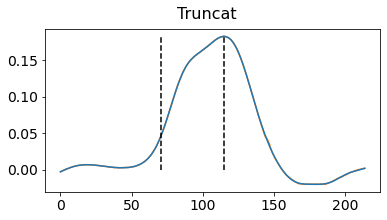


MLSi20HV7kV10mL20Hz - Trial19 - Seg2
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.183 (bar) in 0.022 (sec)

(211,)
0.19534094290432502
0.17561636470524142


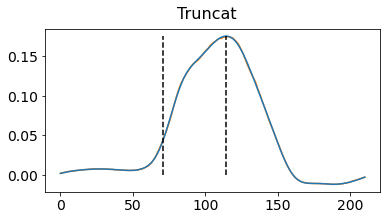


MLSi20HV7kV10mL20Hz - Trial19 - Seg3
Avg. Pressure of zipping = 0.131 (bar), Max. P. = 0.175 (bar) in 0.021 (sec)

(215,)
0.19901360923643424
0.17840909621272752


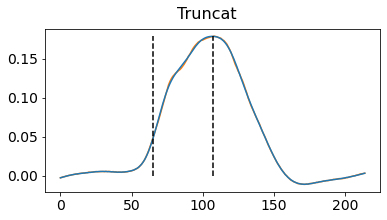


MLSi20HV7kV10mL20Hz - Trial19 - Seg4
Avg. Pressure of zipping = 0.135 (bar), Max. P. = 0.179 (bar) in 0.021 (sec)

(222,)
0.19694472732882687
0.17584205993872168


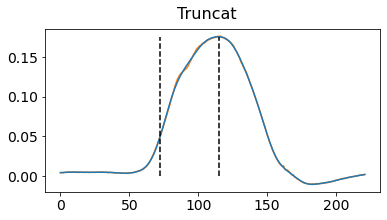


MLSi20HV7kV10mL20Hz - Trial19 - Seg5
Avg. Pressure of zipping = 0.134 (bar), Max. P. = 0.177 (bar) in 0.021 (sec)

(221,)
0.20355231915777447
0.1848420492473824


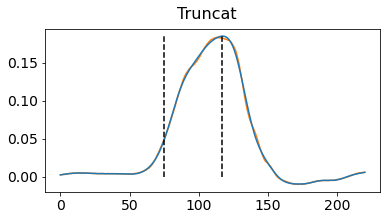


MLSi20HV7kV10mL20Hz - Trial19 - Seg6
Avg. Pressure of zipping = 0.137 (bar), Max. P. = 0.183 (bar) in 0.021 (sec)

(226,)
0.19971927438321507
0.17921003037903635


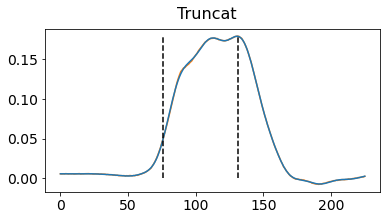


MLSi20HV7kV10mL20Hz - Trial19 - Seg7
Avg. Pressure of zipping = 0.148 (bar), Max. P. = 0.179 (bar) in 0.028 (sec)

(223,)
0.19325602315247262
0.17161875880058317


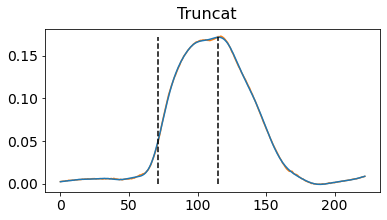


MLSi20HV7kV10mL20Hz - Trial19 - Seg8
Avg. Pressure of zipping = 0.139 (bar), Max. P. = 0.173 (bar) in 0.022 (sec)



In [48]:
'''Measurement 2022 Frequency comparison'''
pressData = []
Fs = 2000

for root, directories, files in walk(".\Data220401Relabelled\Act6Freq"):
    for fileName in files:
         if (fileName[-3:] == 'csv'):    
                condi, names, trialNum, sigFreq = decodeFileName2(fileName)
                
                trialArray = np.arange(1, 40, 2.22)/sigFreq
                beginInd = (Fs * np.array(0.1 + trialArray)).astype(int)
                endInd = (Fs * np.array(0.1 + 2/sigFreq + trialArray)).astype(int)
                
                data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
                
                data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2), channel (0) is current
                
                dataMin = np.min(data) 
                if dataMin < 0:
                    data = data-dataMin # Rectify data

                inactivePressure = np.min(data[:int(0.5*Fs)])
                
                cutInd = cutRepeatTrial(data, Fs, inactivePressure, 20, 8)           
                
                for i in range(len(cutInd)-1): 
                    avgPressure, deltaT, maxPressure, segInd = processPressure(data[cutInd[i]:cutInd[i+1]], Fs, 
                                                                               inactivePressure, 100, 10)
                    P0 = data[cutInd[i]+segInd[0]]-inactivePressure

                    print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
                    print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
                          (avgPressure, maxPressure, deltaT))
                    pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
                                    (data[cutInd[i]:cutInd[i]+int(1.5*segInd[1])] - inactivePressure)*100, segInd, sigFreq]) # 1 bar = 100 kPa
                    
pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
                                               'P0_kPa','PressSig_kPa','SegIndex', 'SigFreq'])

sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
pressData.to_csv("Measurements.csv")


# ''' Incorrect Index? '''
# for i in sigData.index:
#     ax,_=aPlot()
#     ax.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
#     ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 10], '--k')
#     ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 10], '--k')
#     ax.set_ylabel('Pressure_kPa')

In [4]:
'''Measurement 2021'''
# Fs = 1000

# pressData = []
# ''' Process measurement data saved as individual csv files by trial '''
# for root, directories, files in walk(".\data\ValidData"):
#     for fileName in files:
#          if (fileName[-3:] == 'csv'):       
#             condi, names, trialNum = decodeFileName(fileName)

#             data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
#             data = (data - calib[1]) * calib[0] # Unit conversion       
#             dataMin = np.min(data) 
#             if dataMin < 0:
#                 data = data-dataMin # Rectify data
            
#             inactivePressure = np.min(data[:int(0.5*Fs)])

#             avgPressure, deltaT, maxPressure, segInd = processPressure(data, Fs, inactivePressure)
#             P0 = data[segInd[0]]-inactivePressure
            
#             print("\n%s - Trial%02d" % (names, trialNum))
#             print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
#                   (avgPressure, maxPressure, deltaT)) 
#             pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
#                              (data[:segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa

# ''' Process data switch three times with reversed polarity from bipolar HV Trek box '''
# beginInd = ((np.array([1, 8, 15]) - 0.1) * Fs).astype(int)
# endInd = ((np.array([5, 12, 19]) + 0.1) * Fs).astype(int)
# for root, directories, files in walk(".\data\TrekData"):
#     for fileName in files:
#          if (fileName[-3:] == 'csv'):
#             condi, names, trialNum = decodeFileName(fileName)

#             data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
#             data = (data - calib[1]) * calib[0] # Unit conversion       
#             dataMin = np.min(data) 
#             if dataMin < 0:
#                 data = data-dataMin # Rectify data

#             inactivePressure = np.min(data[:int(0.5*Fs)])

#             for i in range(len(beginInd)): 
#                 avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
#                 P0 = data[beginInd[i]+segInd[0]]-inactivePressure
                
#                 print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
#                 print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
#                       (avgPressure, maxPressure, deltaT))
#                 pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
#                                 (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa

# ''' Process data driven by reversed polarity from bipolar wearable controller '''                
# for root, directories, files in walk(".\data\ValidData2"):
#     for fileName in files:
#          if (fileName[-3:] == 'csv'):       
#             condi, names, trialNum = decodeFileName(fileName)
#             names = re.split('U6900V', names)[0] # Shorten the names

#             data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')     
            
#             data = (data[:,1] - calib[1]) * calib[0] # Unit conversion and only keep used channel (1)
            
#             dataMin = np.min(data) 
#             if dataMin < 0:
#                 data = data-dataMin # Rectify data
            
#             inactivePressure = np.min(data[:int(0.5*Fs)])

#             avgPressure, deltaT, maxPressure, segInd = processPressure(data[:int(3.5*Fs)], Fs, inactivePressure)
#             P0 = data[segInd[0]]-inactivePressure
            
#             print("\n%s - Trial%02d" % (names, trialNum))
#             print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
#                   (avgPressure, maxPressure, deltaT)) 
#             pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
#                              (data[:segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa

# ''' Process data switch two times with reversed polarity from bipolar HV Trek box (2022) '''
# beginInd = ((np.array([1.5, 4]) - 0.1) * Fs).astype(int)
# endInd = ((np.array([3, 5.5]) + 0.1) * Fs).astype(int)
# for root, directories, files in walk(".\data\TrekData2"):
#     for fileName in files:
#          if (fileName[-3:] == 'csv'):
#             condi, names, trialNum = decodeFileName(fileName)

#             data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            
#             data = (data[:,2] - calib[1]) * calib[0] # Unit conversion and only keep used channel (2) 
#             dataMin = np.min(data) 
#             if dataMin < 0:
#                 data = data-dataMin # Rectify data

#             inactivePressure = np.min(data[:int(0.5*Fs)])

#             for i in range(len(beginInd)): 
#                 avgPressure, deltaT, maxPressure, segInd = processPressure(data[beginInd[i]:endInd[i]], Fs, inactivePressure)
#                 P0 = data[beginInd[i]+segInd[0]]-inactivePressure # To remove DC pressure
                
#                 print("\n%s - Trial%02d - Seg%d" % (names, trialNum, i+1))
#                 print("Avg. Pressure of zipping = %.3f (bar), Max. P. = %.3f (bar) in %.3f (sec)\n" % 
#                       (avgPressure, maxPressure, deltaT))
#                 pressData.append([names, avgPressure*100, deltaT, maxPressure*100, P0*100,
#                                 (data[beginInd[i]:beginInd[i]+segInd[1]+int(0.5*Fs)]-inactivePressure)*100, segInd]) # 1 bar = 100 kPa
                                      
# pressData = pd.DataFrame(pressData, columns = ['CondiName','AvgPressure_kPa','RiseTime_sec','MaxPressure_kPa',
#                                                'P0_kPa','PressSig_kPa','SegIndex'])

# for aCondi in condiTable['CondiName']: # Drop any extra measurement more than five trials
#     allTrials = pressData[pressData['CondiName'] == aCondi]
#     trialNum = allTrials.shape[0]
#     if trialNum > 5:
#         pressData = pressData.drop(pressData[pressData['CondiName'] == aCondi].index)
#         pressData = pressData.append(allTrials.iloc[:5])

# sigData = pressData[['CondiName','PressSig_kPa','SegIndex']] 
     
# pressData = pressData.drop(columns=['PressSig_kPa','SegIndex'])
# pressData.to_csv("Measurements.csv")



'Measurement 2021'

In [6]:
print(sigData.head())
simData = pd.read_csv("./data./temp_result.csv") # Data from model simulation
simData.tail()

            CondiName                                       PressSig_kPa  \
0  MLSi20HV7kV6mL.5Hz  [0.07858543680059052, 0.046509748310553586, 0....   
1  MLSi20HV7kV6mL.5Hz  [0.30151147180634735, 0.3416060824188935, 0.34...   
2  MLSi20HV7kV6mL.5Hz  [0.49556938717107096, 0.4442482855870118, 0.41...   
3  MLSi20HV7kV6mL.5Hz  [0.1940579153647235, 0.2341525259772697, 0.213...   
4  MLSi20HV7kV6mL.5Hz  [0.25179415464679006, 0.263020645618303, 0.291...   

      SegIndex  
0  [502, 1269]  
1  [508, 1193]  
2  [746, 2968]  
3  [704, 1301]  
4  [775, 2355]  


CondiName      PFull_Pa    P1Expan_Pa    P2Expan_Pa  \
6   MLSi20HV7kV10mL20Hz  14718.181856  14718.181856  14656.266348   
7    MLSi20HV7kV6mL.5Hz  19818.711502  19818.711502  19740.115144   
8    MLSi20HV7kV7mL.5Hz  16618.635713  16618.635713  16550.523565   
9    MLSi20HV7kV8mL.5Hz  14718.181856  14718.181856  14656.266348   
10  MLSi20HV7kV10mL.5Hz  14718.181856  14718.181856  14656.266348   

       P1Cell_Pa  EsFull_J  Es1Expan_J  Es2Expan_J  Es1Cell_J  dVFull_m3  \
6   16025.829787  0.227710    0.177108    0.128297   0.009964   0.000008   
7   21471.036681  0.237756    0.184921    0.133962   0.010396   0.000006   
8   18054.123501  0.232630    0.180934    0.131070   0.010176   0.000007   
9   16025.829787  0.227710    0.177108    0.128297   0.009964   0.000008   
10  16025.829787  0.227710    0.177108    0.128297   0.009964   0.000008   

    dV1Expan_m3  dV2Expan_m3    dV1Cell_m3    lossFactor  
6      0.000006     0.000004  3.108591e-07  1.098169e+08  
7      0.000005     0.000003  2.421022e-07  1.098169e+08  
8      0.000005     0.000004  2.818248e-07  1.098169e+08  
9      0.000006     0.000004  3.108591e-07  1.098169e+08  
10     0.000006     0.000004  3.108591e-07  1.098169e+08

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.608 kPa to P1 = 10.537 kPa
Time-average pressure = 7.504 kPa (gap to max. = 3.033 kPa)
Compressed-air steady state volume = 0.247489 mL
time avg. flow rate = -1.968 mL/s and pressure loss = -0.216 kPa


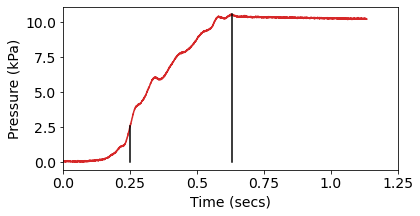

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.505 kPa to P1 = 10.195 kPa
Time-average pressure = 6.279 kPa (gap to max. = 3.916 kPa)
Compressed-air steady state volume = 0.245713 mL
time avg. flow rate = -2.194 mL/s and pressure loss = -0.241 kPa


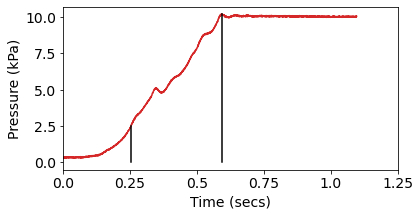

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.471 kPa to P1 = 14.327 kPa
Time-average pressure = 9.375 kPa (gap to max. = 4.952 kPa)
Compressed-air steady state volume = 0.242248 mL
time avg. flow rate = -0.686 mL/s and pressure loss = -0.075 kPa


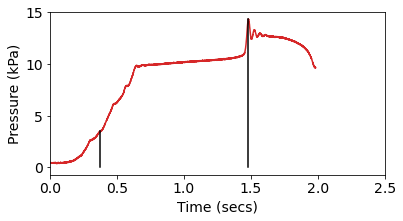

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.866 kPa to P1 = 11.499 kPa
Time-average pressure = 6.951 kPa (gap to max. = 4.548 kPa)
Compressed-air steady state volume = 0.249233 mL
time avg. flow rate = -2.579 mL/s and pressure loss = -0.283 kPa


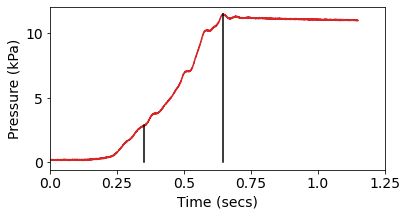

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.430 kPa to P1 = 14.264 kPa
Time-average pressure = 8.780 kPa (gap to max. = 5.484 kPa)
Compressed-air steady state volume = 0.240499 mL
time avg. flow rate = -0.952 mL/s and pressure loss = -0.105 kPa


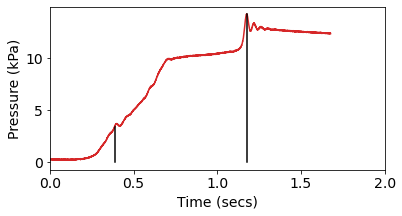

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.615 kPa to P1 = 15.005 kPa
Time-average pressure = 7.465 kPa (gap to max. = 7.540 kPa)
Compressed-air steady state volume = 0.240915 mL
time avg. flow rate = -2.351 mL/s and pressure loss = -0.258 kPa


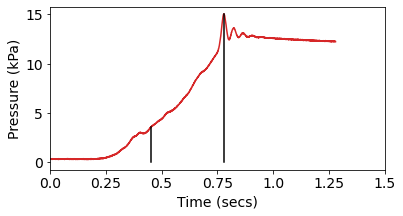

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.575 kPa to P1 = 14.846 kPa
Time-average pressure = 7.171 kPa (gap to max. = 7.676 kPa)
Compressed-air steady state volume = 0.240791 mL
time avg. flow rate = -2.495 mL/s and pressure loss = -0.274 kPa


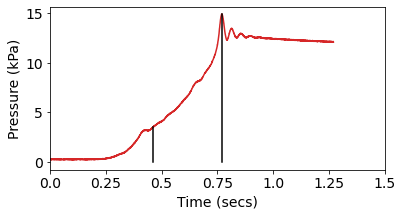

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.536 kPa to P1 = 15.026 kPa
Time-average pressure = 7.018 kPa (gap to max. = 8.008 kPa)
Compressed-air steady state volume = 0.235351 mL
time avg. flow rate = -2.643 mL/s and pressure loss = -0.290 kPa


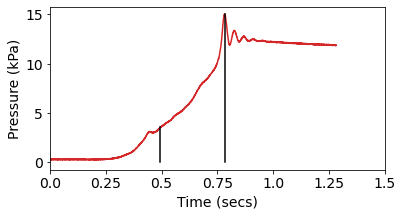

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.270 kPa to P1 = 13.809 kPa
Time-average pressure = 6.454 kPa (gap to max. = 7.355 kPa)
Compressed-air steady state volume = 0.236818 mL
time avg. flow rate = -2.860 mL/s and pressure loss = -0.314 kPa


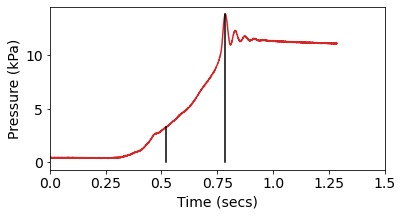

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.403 kPa to P1 = 14.609 kPa
Time-average pressure = 6.657 kPa (gap to max. = 7.952 kPa)
Compressed-air steady state volume = 0.232956 mL
time avg. flow rate = -2.883 mL/s and pressure loss = -0.317 kPa


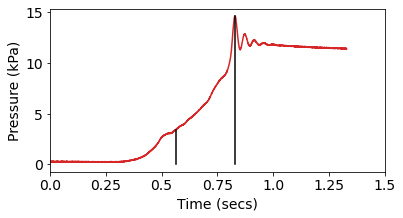

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 3.203 kPa to P1 = 13.489 kPa
Time-average pressure = 6.161 kPa (gap to max. = 7.328 kPa)
Compressed-air steady state volume = 0.237427 mL
time avg. flow rate = -3.162 mL/s and pressure loss = -0.347 kPa


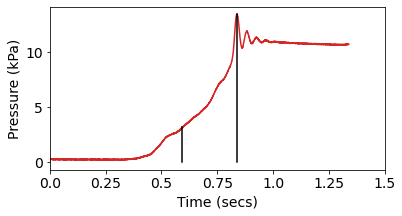

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.702 kPa to P1 = 11.557 kPa
Time-average pressure = 5.325 kPa (gap to max. = 6.232 kPa)
Compressed-air steady state volume = 0.233833 mL
time avg. flow rate = -3.484 mL/s and pressure loss = -0.383 kPa


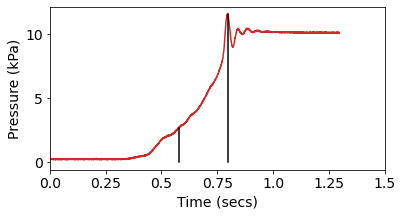

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.799 kPa to P1 = 11.084 kPa
Time-average pressure = 6.283 kPa (gap to max. = 4.800 kPa)
Compressed-air steady state volume = 0.252496 mL
time avg. flow rate = -2.197 mL/s and pressure loss = -0.241 kPa


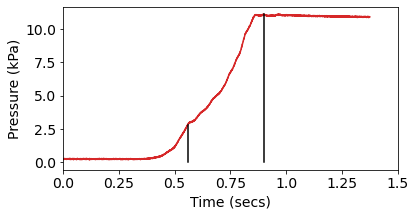

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.709 kPa to P1 = 10.712 kPa
Time-average pressure = 6.759 kPa (gap to max. = 3.953 kPa)
Compressed-air steady state volume = 0.252882 mL
time avg. flow rate = -2.321 mL/s and pressure loss = -0.255 kPa


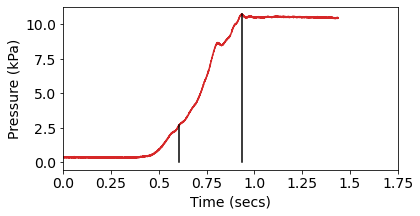

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.678 kPa to P1 = 10.676 kPa
Time-average pressure = 6.523 kPa (gap to max. = 4.154 kPa)
Compressed-air steady state volume = 0.250864 mL
time avg. flow rate = -2.673 mL/s and pressure loss = -0.294 kPa


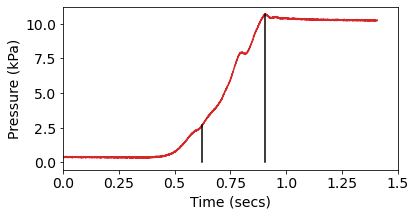

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.627 kPa to P1 = 10.643 kPa
Time-average pressure = 6.890 kPa (gap to max. = 3.753 kPa)
Compressed-air steady state volume = 0.246835 mL
time avg. flow rate = -2.432 mL/s and pressure loss = -0.267 kPa


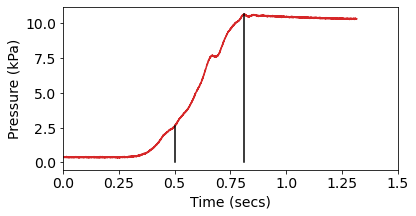

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.659 kPa to P1 = 10.450 kPa
Time-average pressure = 6.735 kPa (gap to max. = 3.715 kPa)
Compressed-air steady state volume = 0.254451 mL
time avg. flow rate = -2.115 mL/s and pressure loss = -0.232 kPa


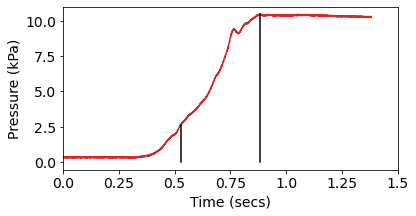

MLSi20HV7kV6mL.5Hz - For pressure increased from P0 = 2.335 kPa to P1 = 9.167 kPa
Time-average pressure = 6.190 kPa (gap to max. = 2.978 kPa)
Compressed-air steady state volume = 0.254724 mL
time avg. flow rate = -2.298 mL/s and pressure loss = -0.252 kPa


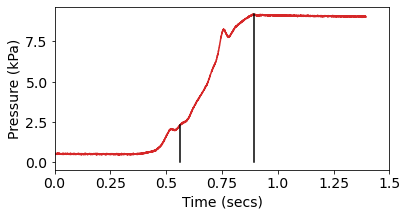

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 3.785 kPa to P1 = 15.448 kPa
Time-average pressure = 10.519 kPa (gap to max. = 4.929 kPa)
Compressed-air steady state volume = 0.245017 mL
time avg. flow rate = -3.004 mL/s and pressure loss = -0.330 kPa


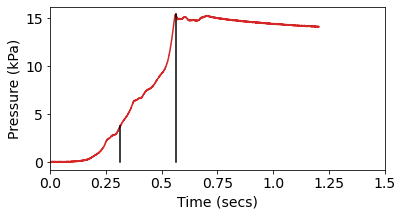

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.819 kPa to P1 = 11.440 kPa
Time-average pressure = 7.476 kPa (gap to max. = 3.963 kPa)
Compressed-air steady state volume = 0.246460 mL
time avg. flow rate = -2.049 mL/s and pressure loss = -0.225 kPa


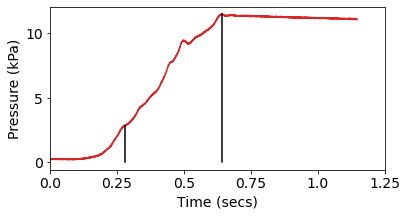

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.759 kPa to P1 = 11.108 kPa
Time-average pressure = 9.639 kPa (gap to max. = 1.468 kPa)
Compressed-air steady state volume = 0.248340 mL
time avg. flow rate = -0.515 mL/s and pressure loss = -0.057 kPa


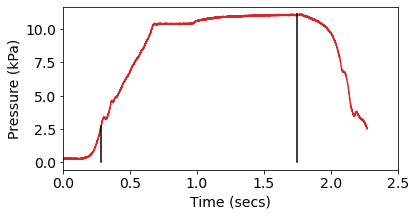

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.855 kPa to P1 = 11.643 kPa
Time-average pressure = 6.985 kPa (gap to max. = 4.658 kPa)
Compressed-air steady state volume = 0.245179 mL
time avg. flow rate = -1.853 mL/s and pressure loss = -0.203 kPa


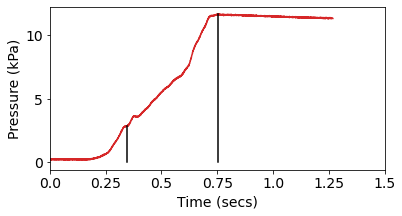

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.712 kPa to P1 = 10.708 kPa
Time-average pressure = 8.438 kPa (gap to max. = 2.271 kPa)
Compressed-air steady state volume = 0.253257 mL
time avg. flow rate = -0.896 mL/s and pressure loss = -0.098 kPa


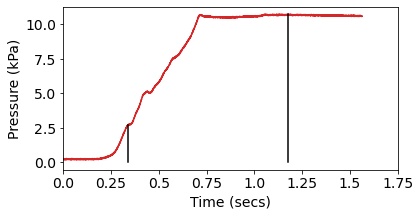

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.880 kPa to P1 = 11.557 kPa
Time-average pressure = 10.271 kPa (gap to max. = 1.286 kPa)
Compressed-air steady state volume = 0.249237 mL
time avg. flow rate = -0.526 mL/s and pressure loss = -0.058 kPa


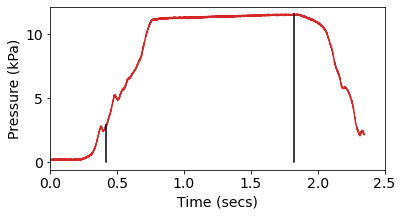

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.861 kPa to P1 = 11.496 kPa
Time-average pressure = 7.412 kPa (gap to max. = 4.084 kPa)
Compressed-air steady state volume = 0.248884 mL
time avg. flow rate = -1.829 mL/s and pressure loss = -0.201 kPa


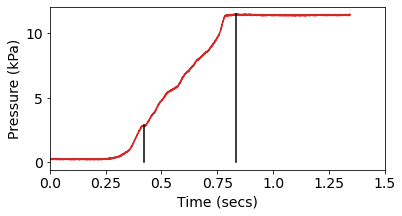

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 3.018 kPa to P1 = 12.022 kPa
Time-average pressure = 7.149 kPa (gap to max. = 4.873 kPa)
Compressed-air steady state volume = 0.251067 mL
time avg. flow rate = -2.120 mL/s and pressure loss = -0.233 kPa


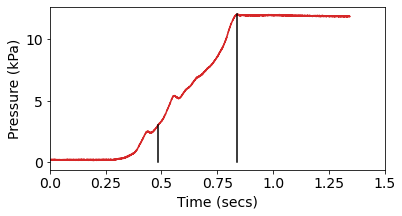

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.860 kPa to P1 = 11.413 kPa
Time-average pressure = 8.992 kPa (gap to max. = 2.421 kPa)
Compressed-air steady state volume = 0.250562 mL
time avg. flow rate = -1.038 mL/s and pressure loss = -0.114 kPa


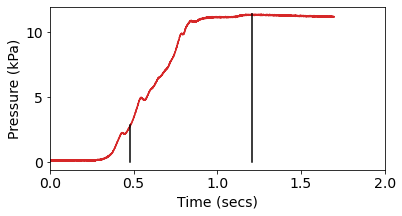

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.983 kPa to P1 = 11.801 kPa
Time-average pressure = 10.025 kPa (gap to max. = 1.776 kPa)
Compressed-air steady state volume = 0.252786 mL
time avg. flow rate = -0.520 mL/s and pressure loss = -0.057 kPa


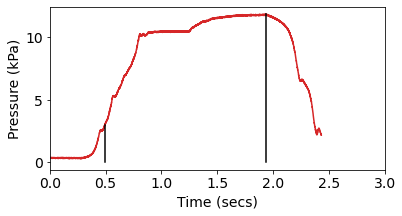

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.895 kPa to P1 = 11.566 kPa
Time-average pressure = 10.261 kPa (gap to max. = 1.305 kPa)
Compressed-air steady state volume = 0.250277 mL
time avg. flow rate = -0.542 mL/s and pressure loss = -0.060 kPa


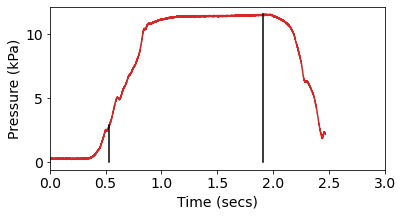

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.895 kPa to P1 = 11.608 kPa
Time-average pressure = 10.386 kPa (gap to max. = 1.222 kPa)
Compressed-air steady state volume = 0.249378 mL
time avg. flow rate = -0.513 mL/s and pressure loss = -0.056 kPa


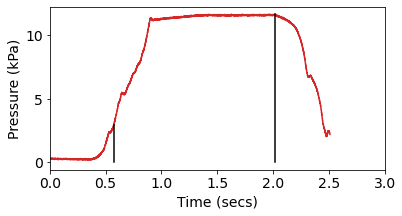

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.837 kPa to P1 = 11.470 kPa
Time-average pressure = 9.333 kPa (gap to max. = 2.137 kPa)
Compressed-air steady state volume = 0.247343 mL
time avg. flow rate = -0.999 mL/s and pressure loss = -0.110 kPa


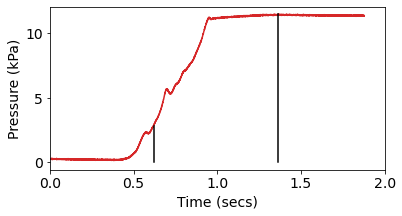

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.799 kPa to P1 = 11.433 kPa
Time-average pressure = 8.991 kPa (gap to max. = 2.443 kPa)
Compressed-air steady state volume = 0.244775 mL
time avg. flow rate = -1.101 mL/s and pressure loss = -0.121 kPa


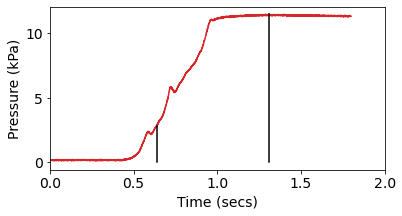

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.815 kPa to P1 = 11.445 kPa
Time-average pressure = 7.938 kPa (gap to max. = 3.507 kPa)
Compressed-air steady state volume = 0.245936 mL
time avg. flow rate = -1.720 mL/s and pressure loss = -0.189 kPa


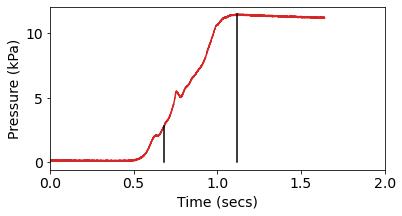

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.917 kPa to P1 = 11.491 kPa
Time-average pressure = 8.082 kPa (gap to max. = 3.409 kPa)
Compressed-air steady state volume = 0.253873 mL
time avg. flow rate = -1.490 mL/s and pressure loss = -0.164 kPa


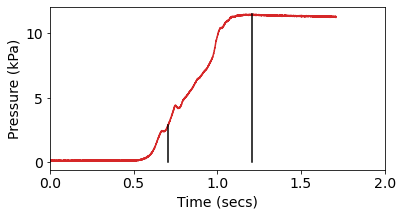

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.898 kPa to P1 = 11.475 kPa
Time-average pressure = 7.649 kPa (gap to max. = 3.826 kPa)
Compressed-air steady state volume = 0.252551 mL
time avg. flow rate = -1.673 mL/s and pressure loss = -0.184 kPa


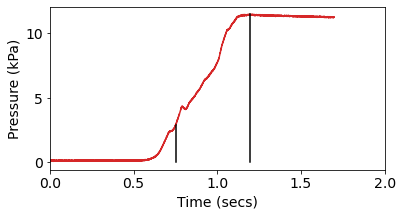

MLSi20HV7kV7mL.5Hz - For pressure increased from P0 = 2.920 kPa to P1 = 11.615 kPa
Time-average pressure = 6.908 kPa (gap to max. = 4.706 kPa)
Compressed-air steady state volume = 0.251450 mL
time avg. flow rate = -1.933 mL/s and pressure loss = -0.212 kPa


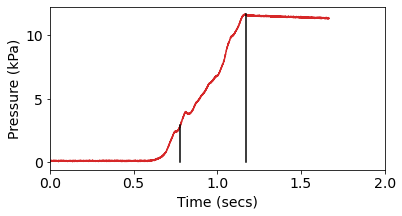

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.536 kPa to P1 = 14.440 kPa
Time-average pressure = 11.726 kPa (gap to max. = 2.715 kPa)
Compressed-air steady state volume = 0.244891 mL
time avg. flow rate = -0.625 mL/s and pressure loss = -0.069 kPa


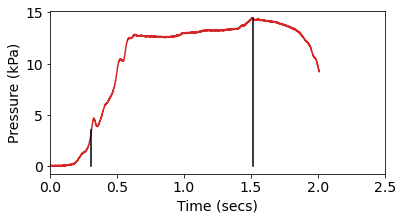

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.649 kPa to P1 = 14.999 kPa
Time-average pressure = 7.680 kPa (gap to max. = 7.318 kPa)
Compressed-air steady state volume = 0.243263 mL
time avg. flow rate = -2.771 mL/s and pressure loss = -0.304 kPa


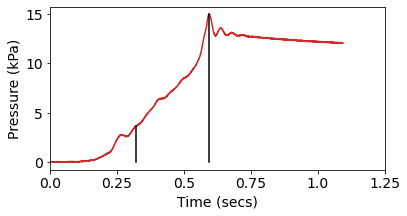

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.898 kPa to P1 = 11.185 kPa
Time-average pressure = 7.747 kPa (gap to max. = 3.438 kPa)
Compressed-air steady state volume = 0.259105 mL
time avg. flow rate = -2.081 mL/s and pressure loss = -0.229 kPa


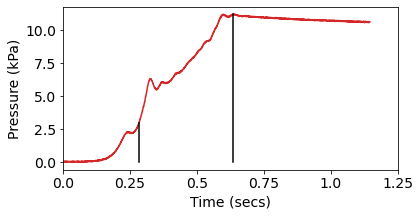

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.597 kPa to P1 = 10.386 kPa
Time-average pressure = 6.915 kPa (gap to max. = 3.471 kPa)
Compressed-air steady state volume = 0.250000 mL
time avg. flow rate = -2.152 mL/s and pressure loss = -0.236 kPa


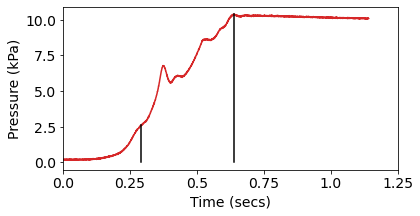

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.287 kPa to P1 = 8.904 kPa
Time-average pressure = 6.503 kPa (gap to max. = 2.401 kPa)
Compressed-air steady state volume = 0.256844 mL
time avg. flow rate = -1.821 mL/s and pressure loss = -0.200 kPa


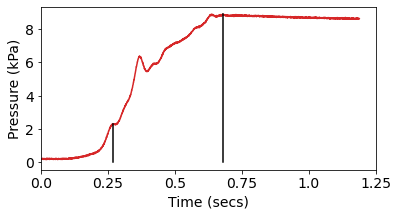

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.335 kPa to P1 = 9.106 kPa
Time-average pressure = 6.822 kPa (gap to max. = 2.285 kPa)
Compressed-air steady state volume = 0.256428 mL
time avg. flow rate = -1.618 mL/s and pressure loss = -0.178 kPa


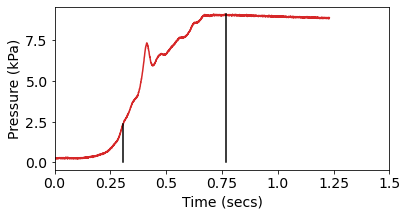

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.354 kPa to P1 = 14.248 kPa
Time-average pressure = 6.903 kPa (gap to max. = 7.345 kPa)
Compressed-air steady state volume = 0.235367 mL
time avg. flow rate = -2.431 mL/s and pressure loss = -0.267 kPa


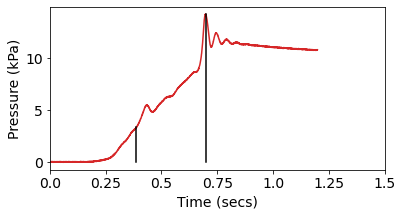

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.276 kPa to P1 = 8.935 kPa
Time-average pressure = 5.829 kPa (gap to max. = 3.106 kPa)
Compressed-air steady state volume = 0.254712 mL
time avg. flow rate = -2.054 mL/s and pressure loss = -0.226 kPa


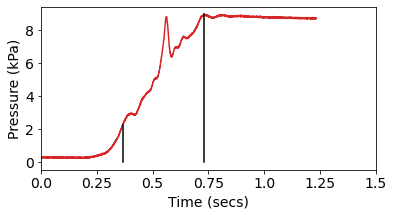

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.300 kPa to P1 = 9.156 kPa
Time-average pressure = 6.121 kPa (gap to max. = 3.035 kPa)
Compressed-air steady state volume = 0.251182 mL
time avg. flow rate = -1.427 mL/s and pressure loss = -0.157 kPa


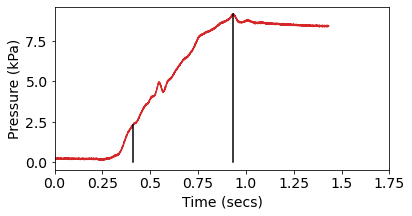

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.087 kPa to P1 = 12.275 kPa
Time-average pressure = 9.648 kPa (gap to max. = 2.627 kPa)
Compressed-air steady state volume = 0.251502 mL
time avg. flow rate = -0.586 mL/s and pressure loss = -0.064 kPa


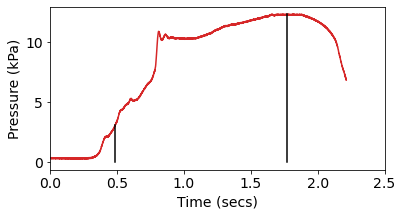

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 1.840 kPa to P1 = 7.554 kPa
Time-average pressure = 6.711 kPa (gap to max. = 0.842 kPa)
Compressed-air steady state volume = 0.243524 mL
time avg. flow rate = -0.506 mL/s and pressure loss = -0.056 kPa


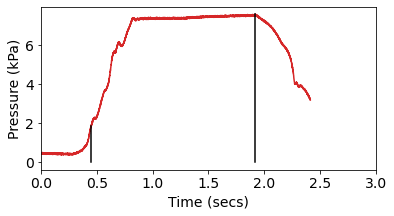

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.853 kPa to P1 = 11.599 kPa
Time-average pressure = 5.305 kPa (gap to max. = 6.294 kPa)
Compressed-air steady state volume = 0.245990 mL
time avg. flow rate = -3.872 mL/s and pressure loss = -0.425 kPa


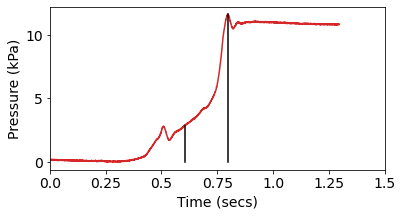

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.054 kPa to P1 = 12.469 kPa
Time-average pressure = 7.164 kPa (gap to max. = 5.306 kPa)
Compressed-air steady state volume = 0.244887 mL
time avg. flow rate = -2.990 mL/s and pressure loss = -0.328 kPa


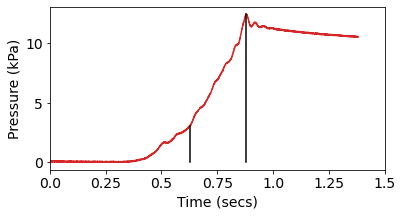

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.012 kPa to P1 = 11.801 kPa
Time-average pressure = 7.330 kPa (gap to max. = 4.471 kPa)
Compressed-air steady state volume = 0.255232 mL
time avg. flow rate = -2.942 mL/s and pressure loss = -0.323 kPa


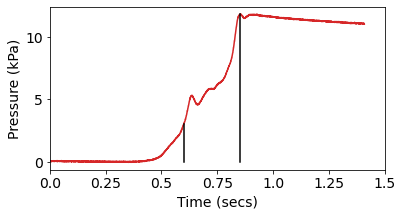

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.618 kPa to P1 = 14.264 kPa
Time-average pressure = 8.487 kPa (gap to max. = 5.777 kPa)
Compressed-air steady state volume = 0.253654 mL
time avg. flow rate = -2.365 mL/s and pressure loss = -0.260 kPa


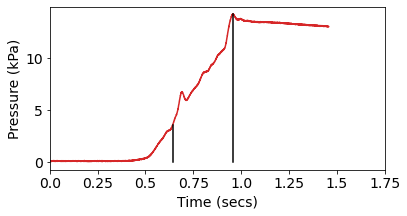

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.483 kPa to P1 = 14.126 kPa
Time-average pressure = 9.604 kPa (gap to max. = 4.522 kPa)
Compressed-air steady state volume = 0.246594 mL
time avg. flow rate = -1.851 mL/s and pressure loss = -0.203 kPa


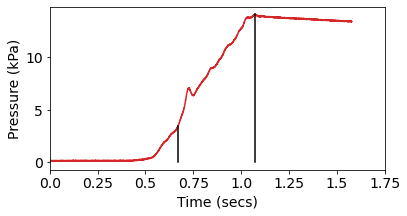

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.349 kPa to P1 = 13.674 kPa
Time-average pressure = 9.102 kPa (gap to max. = 4.572 kPa)
Compressed-air steady state volume = 0.244898 mL
time avg. flow rate = -2.005 mL/s and pressure loss = -0.220 kPa


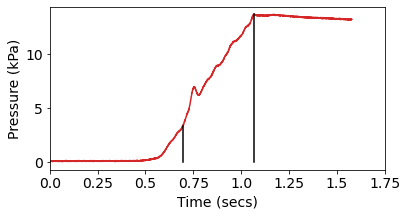

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.453 kPa to P1 = 13.969 kPa
Time-average pressure = 9.510 kPa (gap to max. = 4.459 kPa)
Compressed-air steady state volume = 0.247187 mL
time avg. flow rate = -1.727 mL/s and pressure loss = -0.190 kPa


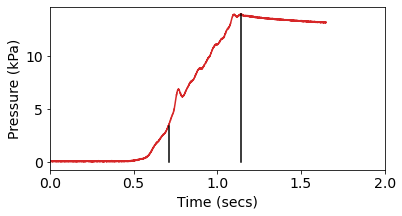

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.825 kPa to P1 = 14.914 kPa
Time-average pressure = 10.076 kPa (gap to max. = 4.838 kPa)
Compressed-air steady state volume = 0.256479 mL
time avg. flow rate = -2.481 mL/s and pressure loss = -0.272 kPa


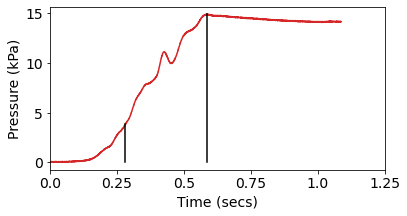

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.714 kPa to P1 = 15.265 kPa
Time-average pressure = 8.385 kPa (gap to max. = 6.879 kPa)
Compressed-air steady state volume = 0.243328 mL
time avg. flow rate = -2.366 mL/s and pressure loss = -0.260 kPa


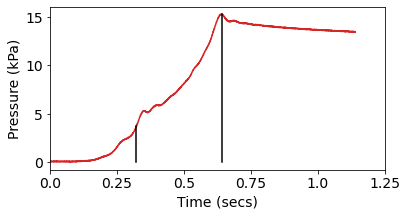

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.721 kPa to P1 = 14.989 kPa
Time-average pressure = 11.774 kPa (gap to max. = 3.215 kPa)
Compressed-air steady state volume = 0.248235 mL
time avg. flow rate = -0.897 mL/s and pressure loss = -0.098 kPa


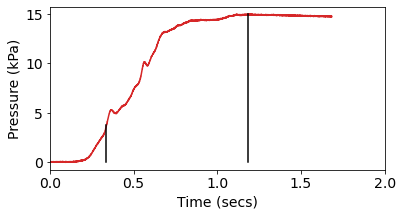

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.710 kPa to P1 = 10.936 kPa
Time-average pressure = 7.163 kPa (gap to max. = 3.773 kPa)
Compressed-air steady state volume = 0.247837 mL
time avg. flow rate = -2.216 mL/s and pressure loss = -0.243 kPa


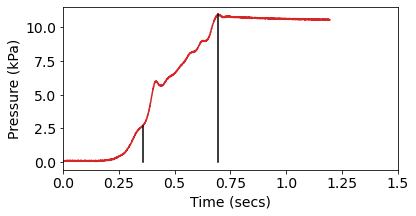

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.829 kPa to P1 = 11.015 kPa
Time-average pressure = 7.986 kPa (gap to max. = 3.029 kPa)
Compressed-air steady state volume = 0.256843 mL
time avg. flow rate = -1.782 mL/s and pressure loss = -0.196 kPa


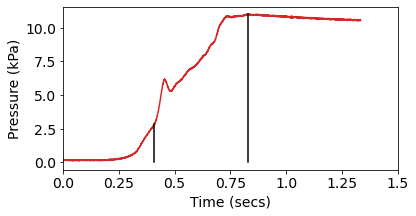

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.868 kPa to P1 = 11.193 kPa
Time-average pressure = 7.467 kPa (gap to max. = 3.726 kPa)
Compressed-air steady state volume = 0.256197 mL
time avg. flow rate = -2.157 mL/s and pressure loss = -0.237 kPa


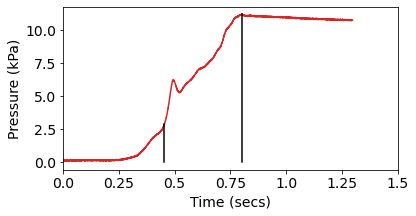

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.741 kPa to P1 = 10.930 kPa
Time-average pressure = 6.953 kPa (gap to max. = 3.976 kPa)
Compressed-air steady state volume = 0.250770 mL
time avg. flow rate = -2.193 mL/s and pressure loss = -0.241 kPa


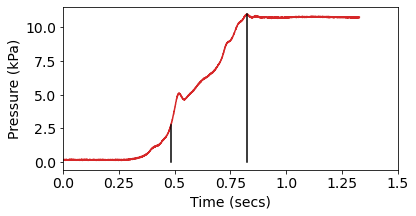

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.786 kPa to P1 = 11.409 kPa
Time-average pressure = 7.466 kPa (gap to max. = 3.943 kPa)
Compressed-air steady state volume = 0.244166 mL
time avg. flow rate = -1.943 mL/s and pressure loss = -0.213 kPa


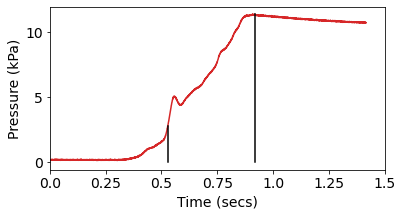

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.861 kPa to P1 = 11.695 kPa
Time-average pressure = 6.838 kPa (gap to max. = 4.857 kPa)
Compressed-air steady state volume = 0.244652 mL
time avg. flow rate = -2.128 mL/s and pressure loss = -0.234 kPa


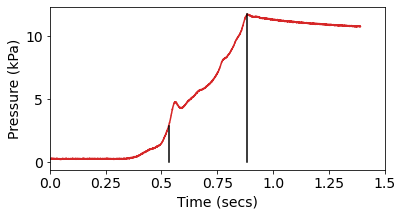

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.973 kPa to P1 = 11.961 kPa
Time-average pressure = 7.031 kPa (gap to max. = 4.930 kPa)
Compressed-air steady state volume = 0.248592 mL
time avg. flow rate = -2.253 mL/s and pressure loss = -0.247 kPa


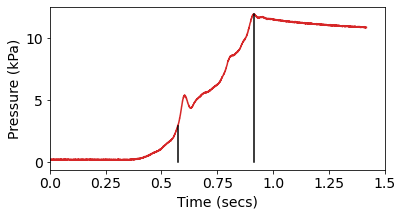

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.890 kPa to P1 = 12.019 kPa
Time-average pressure = 6.952 kPa (gap to max. = 5.067 kPa)
Compressed-air steady state volume = 0.240459 mL
time avg. flow rate = -2.218 mL/s and pressure loss = -0.244 kPa


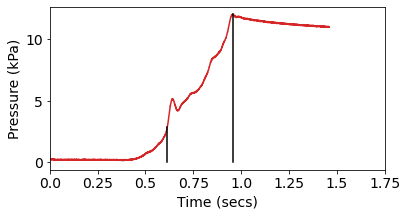

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.887 kPa to P1 = 12.028 kPa
Time-average pressure = 7.020 kPa (gap to max. = 5.008 kPa)
Compressed-air steady state volume = 0.240000 mL
time avg. flow rate = -2.268 mL/s and pressure loss = -0.249 kPa


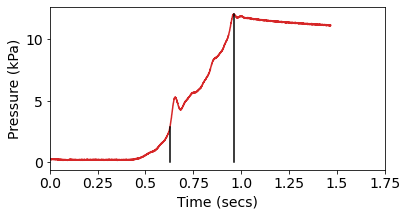

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.895 kPa to P1 = 12.065 kPa
Time-average pressure = 6.903 kPa (gap to max. = 5.162 kPa)
Compressed-air steady state volume = 0.239931 mL
time avg. flow rate = -2.179 mL/s and pressure loss = -0.239 kPa


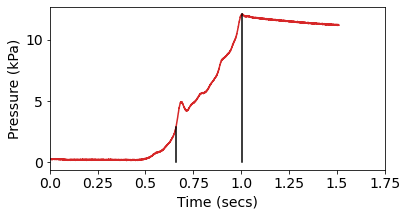

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.940 kPa to P1 = 12.234 kPa
Time-average pressure = 6.887 kPa (gap to max. = 5.347 kPa)
Compressed-air steady state volume = 0.240299 mL
time avg. flow rate = -2.193 mL/s and pressure loss = -0.241 kPa


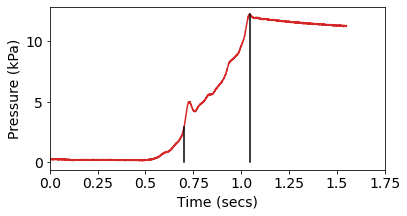

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.985 kPa to P1 = 12.266 kPa
Time-average pressure = 6.620 kPa (gap to max. = 5.645 kPa)
Compressed-air steady state volume = 0.243332 mL
time avg. flow rate = -2.147 mL/s and pressure loss = -0.236 kPa


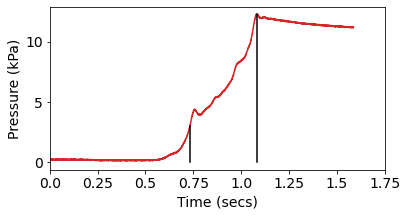

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.036 kPa to P1 = 12.258 kPa
Time-average pressure = 6.536 kPa (gap to max. = 5.722 kPa)
Compressed-air steady state volume = 0.247678 mL
time avg. flow rate = -2.177 mL/s and pressure loss = -0.239 kPa


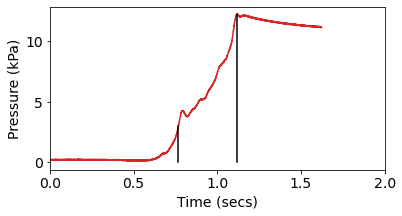

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 3.123 kPa to P1 = 12.356 kPa
Time-average pressure = 7.365 kPa (gap to max. = 4.991 kPa)
Compressed-air steady state volume = 0.252726 mL
time avg. flow rate = -2.218 mL/s and pressure loss = -0.244 kPa


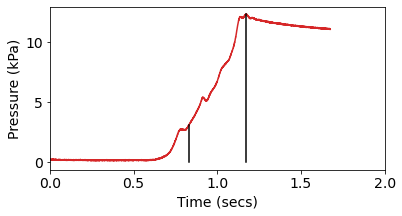

MLSi20HV7kV8mL.5Hz - For pressure increased from P0 = 2.739 kPa to P1 = 11.117 kPa
Time-average pressure = 6.063 kPa (gap to max. = 5.054 kPa)
Compressed-air steady state volume = 0.246394 mL
time avg. flow rate = -2.637 mL/s and pressure loss = -0.290 kPa


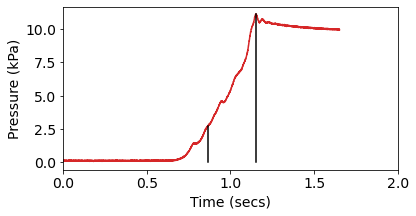

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 3.560 kPa to P1 = 14.102 kPa
Time-average pressure = 10.907 kPa (gap to max. = 3.195 kPa)
Compressed-air steady state volume = 0.252474 mL
time avg. flow rate = -0.551 mL/s and pressure loss = -0.061 kPa


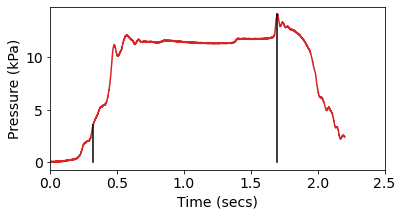

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 3.166 kPa to P1 = 13.145 kPa
Time-average pressure = 6.468 kPa (gap to max. = 6.677 kPa)
Compressed-air steady state volume = 0.240849 mL
time avg. flow rate = -3.039 mL/s and pressure loss = -0.334 kPa


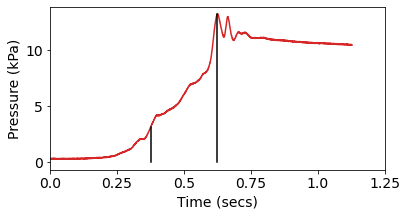

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 3.124 kPa to P1 = 12.721 kPa
Time-average pressure = 6.310 kPa (gap to max. = 6.411 kPa)
Compressed-air steady state volume = 0.245587 mL
time avg. flow rate = -3.032 mL/s and pressure loss = -0.333 kPa


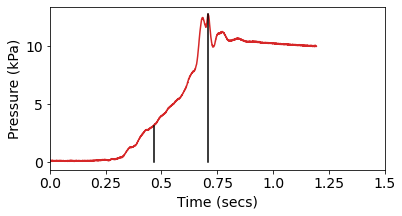

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.606 kPa to P1 = 11.334 kPa
Time-average pressure = 5.880 kPa (gap to max. = 5.454 kPa)
Compressed-air steady state volume = 0.229942 mL
time avg. flow rate = -3.336 mL/s and pressure loss = -0.366 kPa


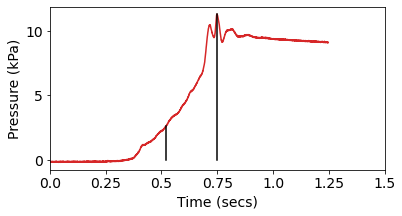

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.026 kPa to P1 = 9.055 kPa
Time-average pressure = 4.716 kPa (gap to max. = 4.339 kPa)
Compressed-air steady state volume = 0.223698 mL
time avg. flow rate = -4.638 mL/s and pressure loss = -0.509 kPa


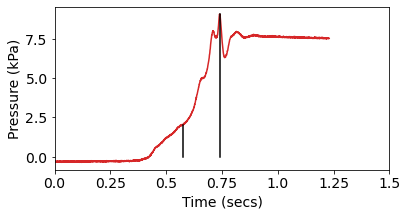

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.961 kPa to P1 = 8.994 kPa
Time-average pressure = 4.791 kPa (gap to max. = 4.203 kPa)
Compressed-air steady state volume = 0.218081 mL
time avg. flow rate = -4.577 mL/s and pressure loss = -0.503 kPa


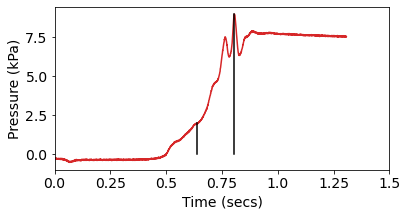

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.994 kPa to P1 = 8.800 kPa
Time-average pressure = 4.475 kPa (gap to max. = 4.325 kPa)
Compressed-air steady state volume = 0.226535 mL
time avg. flow rate = -4.360 mL/s and pressure loss = -0.479 kPa


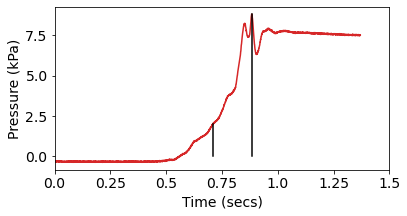

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.965 kPa to P1 = 8.577 kPa
Time-average pressure = 5.382 kPa (gap to max. = 3.195 kPa)
Compressed-air steady state volume = 0.229058 mL
time avg. flow rate = -4.508 mL/s and pressure loss = -0.495 kPa


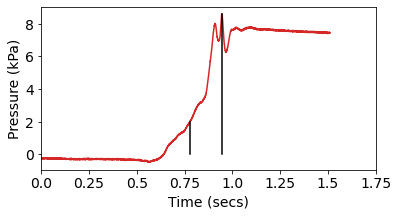

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.912 kPa to P1 = 7.634 kPa
Time-average pressure = 5.294 kPa (gap to max. = 2.340 kPa)
Compressed-air steady state volume = 0.250420 mL
time avg. flow rate = -2.413 mL/s and pressure loss = -0.265 kPa


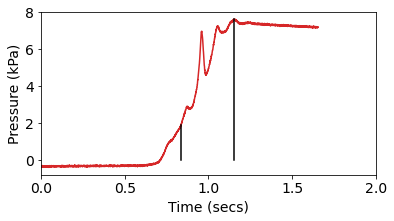

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.902 kPa to P1 = 7.618 kPa
Time-average pressure = 5.196 kPa (gap to max. = 2.422 kPa)
Compressed-air steady state volume = 0.249684 mL
time avg. flow rate = -2.442 mL/s and pressure loss = -0.268 kPa


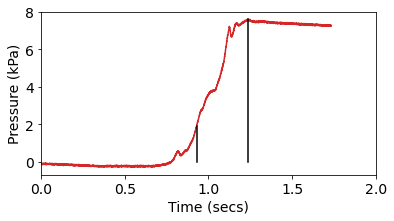

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.928 kPa to P1 = 7.557 kPa
Time-average pressure = 5.201 kPa (gap to max. = 2.356 kPa)
Compressed-air steady state volume = 0.255093 mL
time avg. flow rate = -2.509 mL/s and pressure loss = -0.276 kPa


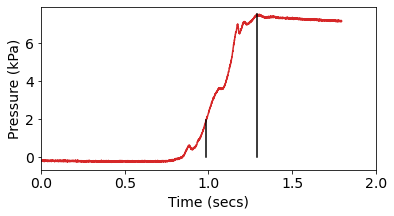

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.892 kPa to P1 = 7.584 kPa
Time-average pressure = 5.272 kPa (gap to max. = 2.312 kPa)
Compressed-air steady state volume = 0.249524 mL
time avg. flow rate = -2.424 mL/s and pressure loss = -0.266 kPa


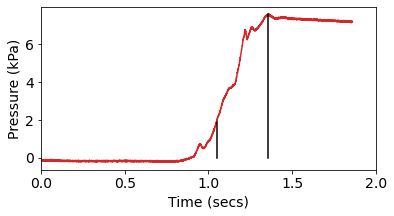

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.891 kPa to P1 = 7.525 kPa
Time-average pressure = 5.337 kPa (gap to max. = 2.188 kPa)
Compressed-air steady state volume = 0.251279 mL
time avg. flow rate = -2.549 mL/s and pressure loss = -0.280 kPa


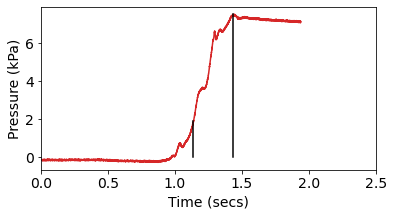

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.872 kPa to P1 = 7.541 kPa
Time-average pressure = 5.205 kPa (gap to max. = 2.336 kPa)
Compressed-air steady state volume = 0.248192 mL
time avg. flow rate = -2.340 mL/s and pressure loss = -0.257 kPa


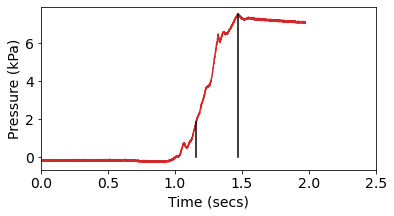

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.867 kPa to P1 = 7.443 kPa
Time-average pressure = 5.305 kPa (gap to max. = 2.138 kPa)
Compressed-air steady state volume = 0.250808 mL
time avg. flow rate = -2.569 mL/s and pressure loss = -0.282 kPa


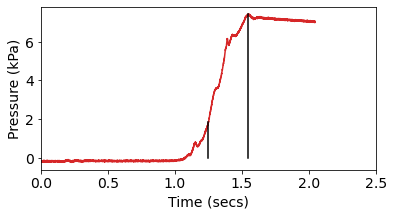

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.856 kPa to P1 = 7.469 kPa
Time-average pressure = 5.258 kPa (gap to max. = 2.211 kPa)
Compressed-air steady state volume = 0.248443 mL
time avg. flow rate = -2.462 mL/s and pressure loss = -0.270 kPa


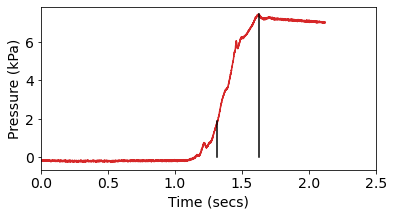

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.852 kPa to P1 = 7.382 kPa
Time-average pressure = 5.267 kPa (gap to max. = 2.115 kPa)
Compressed-air steady state volume = 0.250923 mL
time avg. flow rate = -2.510 mL/s and pressure loss = -0.276 kPa


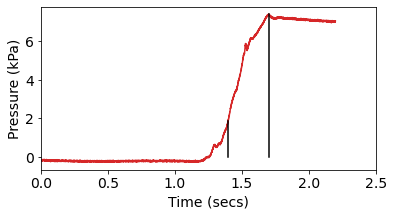

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 1.822 kPa to P1 = 7.411 kPa
Time-average pressure = 5.245 kPa (gap to max. = 2.166 kPa)
Compressed-air steady state volume = 0.245834 mL
time avg. flow rate = -2.495 mL/s and pressure loss = -0.274 kPa


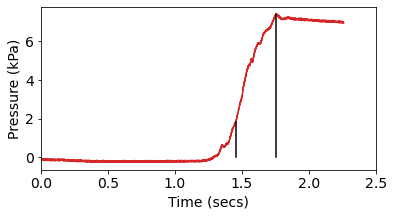

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 3.602 kPa to P1 = 14.372 kPa
Time-average pressure = 8.124 kPa (gap to max. = 6.248 kPa)
Compressed-air steady state volume = 0.250642 mL
time avg. flow rate = -3.132 mL/s and pressure loss = -0.344 kPa


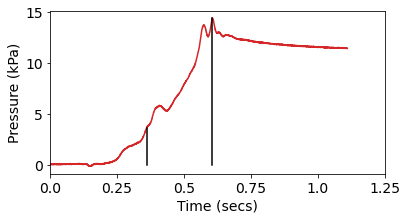

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 3.188 kPa to P1 = 13.098 kPa
Time-average pressure = 7.129 kPa (gap to max. = 5.969 kPa)
Compressed-air steady state volume = 0.243419 mL
time avg. flow rate = -3.504 mL/s and pressure loss = -0.385 kPa


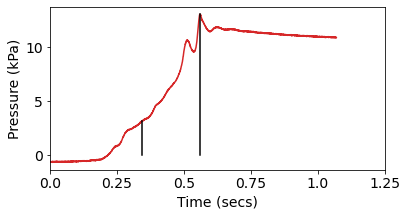

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.874 kPa to P1 = 11.772 kPa
Time-average pressure = 7.891 kPa (gap to max. = 3.881 kPa)
Compressed-air steady state volume = 0.244142 mL
time avg. flow rate = -4.217 mL/s and pressure loss = -0.463 kPa


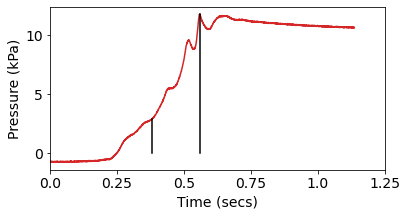

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.935 kPa to P1 = 11.874 kPa
Time-average pressure = 7.646 kPa (gap to max. = 4.228 kPa)
Compressed-air steady state volume = 0.247164 mL
time avg. flow rate = -2.986 mL/s and pressure loss = -0.328 kPa


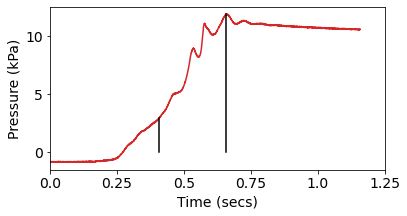

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.937 kPa to P1 = 11.714 kPa
Time-average pressure = 7.563 kPa (gap to max. = 4.151 kPa)
Compressed-air steady state volume = 0.250685 mL
time avg. flow rate = -3.006 mL/s and pressure loss = -0.330 kPa


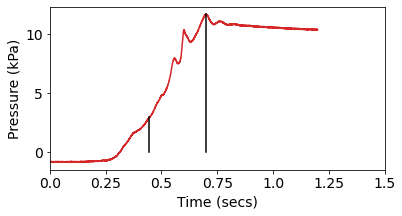

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.888 kPa to P1 = 11.663 kPa
Time-average pressure = 7.426 kPa (gap to max. = 4.237 kPa)
Compressed-air steady state volume = 0.247662 mL
time avg. flow rate = -3.058 mL/s and pressure loss = -0.336 kPa


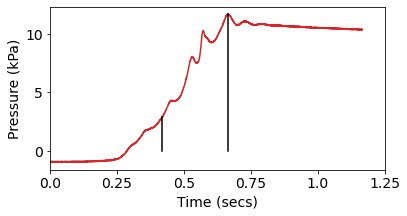

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.818 kPa to P1 = 11.501 kPa
Time-average pressure = 7.340 kPa (gap to max. = 4.161 kPa)
Compressed-air steady state volume = 0.245015 mL
time avg. flow rate = -3.027 mL/s and pressure loss = -0.332 kPa


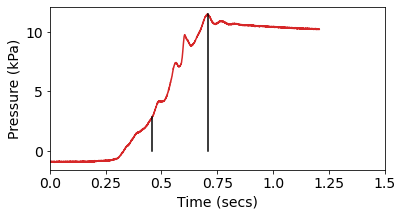

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.819 kPa to P1 = 11.396 kPa
Time-average pressure = 7.172 kPa (gap to max. = 4.225 kPa)
Compressed-air steady state volume = 0.247397 mL
time avg. flow rate = -3.039 mL/s and pressure loss = -0.334 kPa


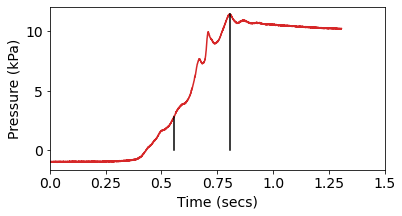

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.781 kPa to P1 = 11.196 kPa
Time-average pressure = 7.072 kPa (gap to max. = 4.124 kPa)
Compressed-air steady state volume = 0.248388 mL
time avg. flow rate = -3.042 mL/s and pressure loss = -0.334 kPa


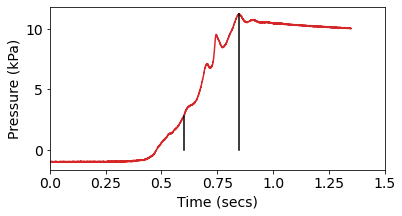

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.786 kPa to P1 = 11.007 kPa
Time-average pressure = 6.975 kPa (gap to max. = 4.031 kPa)
Compressed-air steady state volume = 0.253096 mL
time avg. flow rate = -3.069 mL/s and pressure loss = -0.337 kPa


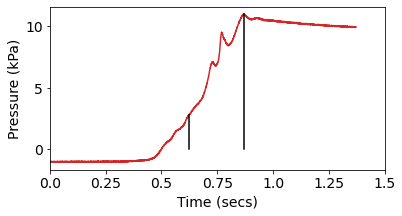

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.709 kPa to P1 = 10.800 kPa
Time-average pressure = 6.845 kPa (gap to max. = 3.955 kPa)
Compressed-air steady state volume = 0.250817 mL
time avg. flow rate = -3.017 mL/s and pressure loss = -0.331 kPa


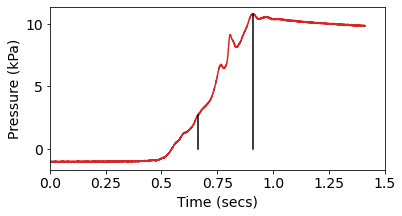

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.693 kPa to P1 = 10.742 kPa
Time-average pressure = 6.993 kPa (gap to max. = 3.749 kPa)
Compressed-air steady state volume = 0.250672 mL
time avg. flow rate = -3.106 mL/s and pressure loss = -0.341 kPa


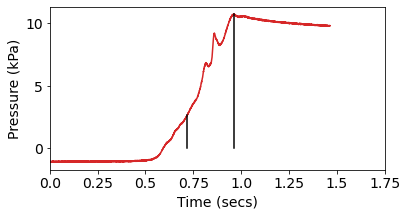

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.683 kPa to P1 = 10.620 kPa
Time-average pressure = 7.104 kPa (gap to max. = 3.516 kPa)
Compressed-air steady state volume = 0.252643 mL
time avg. flow rate = -2.841 mL/s and pressure loss = -0.312 kPa


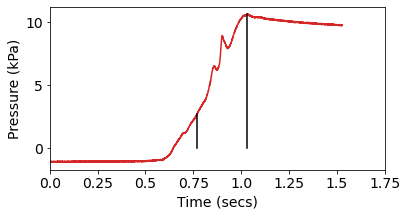

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.678 kPa to P1 = 10.559 kPa
Time-average pressure = 6.962 kPa (gap to max. = 3.598 kPa)
Compressed-air steady state volume = 0.253645 mL
time avg. flow rate = -2.663 mL/s and pressure loss = -0.292 kPa


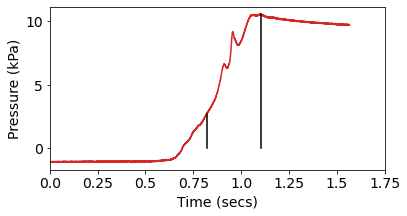

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.665 kPa to P1 = 10.564 kPa
Time-average pressure = 6.852 kPa (gap to max. = 3.712 kPa)
Compressed-air steady state volume = 0.252315 mL
time avg. flow rate = -3.130 mL/s and pressure loss = -0.344 kPa


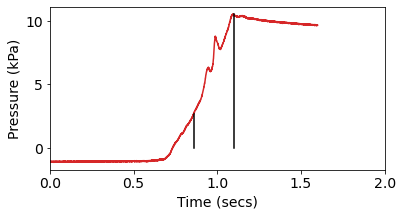

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.662 kPa to P1 = 10.569 kPa
Time-average pressure = 7.287 kPa (gap to max. = 3.282 kPa)
Compressed-air steady state volume = 0.251897 mL
time avg. flow rate = -2.738 mL/s and pressure loss = -0.301 kPa


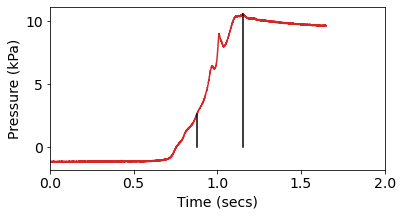

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.629 kPa to P1 = 10.513 kPa
Time-average pressure = 7.171 kPa (gap to max. = 3.342 kPa)
Compressed-air steady state volume = 0.250038 mL
time avg. flow rate = -2.698 mL/s and pressure loss = -0.296 kPa


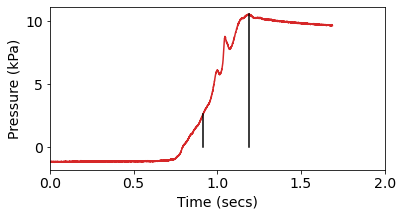

MLSi20HV7kV10mL.5Hz - For pressure increased from P0 = 2.632 kPa to P1 = 10.518 kPa
Time-average pressure = 7.119 kPa (gap to max. = 3.398 kPa)
Compressed-air steady state volume = 0.250229 mL
time avg. flow rate = -2.745 mL/s and pressure loss = -0.301 kPa


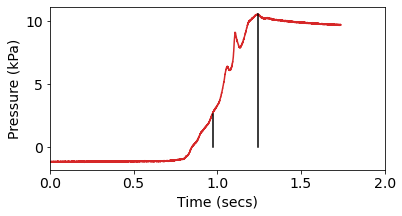

In [12]:
''' New estimation of air volume (2022.04.06) '''
airV0 = 1e-6 # Unit: m3, Initial air volume is roughly estimated to be 1? mL. (volume of inner tube is around 1.8 mL)
 
''' By law of P0V0 = P1V1, with P0 and P1 took from the measurement'''
avgPressLoss = []
for i in sigData.index:
#     airV0 = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0] # Incorrect Assume all oil pushed to tube
    
    i0 = sigData.loc[i,'SegIndex'][0] # Starting index at lowest pressure
    try:
        i1 = np.argwhere(sigData.loc[i,'PressSig_kPa'] == pressData.loc[i,'MaxPressure_kPa'])[0][0] # End index at max pressure
    except:
        i1 = sigData.loc[i,'SegIndex'][1]
    P0 = pressData.loc[i,'P0_kPa']
    P1 = pressData.loc[i,'MaxPressure_kPa']
    
    airV1 = airV0 * P0/P1
    print("%s - For pressure increased from P0 = %.3f kPa to P1 = %.3f kPa" % (sigData.loc[i,'CondiName'],
          pressData.loc[i,'P0_kPa'], pressData.loc[i,'MaxPressure_kPa']))
    print("Time-average pressure = %.3f kPa (gap to max. = %.3f kPa)" % (pressData.loc[i,'AvgPressure_kPa'],
            pressData.loc[i,'MaxPressure_kPa'] - pressData.loc[i,'AvgPressure_kPa']))
    print("Compressed-air steady state volume = %.6f mL" % (airV1 * 1e6))
    
    filtPressure = lowpassFilter(sigData.loc[i,'PressSig_kPa'], 30, Fs, 6) # Smooth volume change before division
    airVi = airV1 * P1 / filtPressure[i0 : i1]  # Unit: m3
    
    Qi = np.diff(airVi) * Fs # Flow rate, Unit: m3/s
    
    PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi *1e-3 # Unit: kPa

    avgPLoss = np.mean(PiLoss) # Unit: kPa
    print("time avg. flow rate = %.3f mL/s and pressure loss = %.3f kPa" % (np.mean(Qi) * 1e6, avgPLoss))
    
    avgPressLoss.append(avgPLoss)
    
    if pressData.loc[i,'MaxPressure_kPa'] > 4: # Check signal 
        ax,_ = aPlot(dpi = 72)
        ax.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
        
#         ax.plot(np.arange(i0+1,i1), PiLoss,color='tab:orange')
        
        ax.plot([i0, i0], [0, pressData.loc[i,'P0_kPa']], '-k')
        ax.plot([i1, i1], [0, pressData.loc[i,'MaxPressure_kPa']], '-k')
#         ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, pressData.loc[i,'MaxPressure_kPa']], '--k')
        ax.set_ylabel('Pressure (kPa)')
        
#         ax2 = ax.twinx() 
#         ax2.plot(np.arange(i0,i1), airVi,color='tab:blue')

        locs, _ = plt.xticks()
        plt.xticks(locs, locs/Fs)
        ax.set_xlim(0, locs[-1])
        ax.set_xlabel('Time (secs)')
        
        plt.show()
    
pressData['P1ExpanLoss_kPa'] = avgPressLoss
pressData.to_csv("Measurements.csv")     
    

In [ ]:
'''
Such estimation of pressure loss in tube is very inaccurate due to incorrect estimation of air volume
'''
''' Both Simulation and Measurement Data required '''
# print("Sampling frequency of current dataset = %.3f Hz" % Fs)

# sigData['V0'] = 0

# avgPressLoss = []
# for i in sigData.index:
#     deltaVolume = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'dV1Expan_m3'].iloc[0]

#     sigData.loc[i,'V0'] = deltaVolume / (1 - pressData.loc[i,'P0_kPa']/pressData.loc[i,'MaxPressure_kPa']) # Unit: m3
    
#     print("Initial Volume (mL) = %f" % (sigData.loc[i,'V0']*1e6))
#     print("Initial Pressure (kPa) = %f" % pressData.loc[i,'P0_kPa'])
#     print(sigData.loc[i,'SegIndex'])
    
#     print("%s inital air volume = %.6f mL" % (sigData.loc[i,'CondiName'], sigData.loc[i,'V0']*1e6)) 
    
#     ''' Realtime volume '''
# #     filteredPressure = lowpassFilter(sigData.loc[i,'PressSig_kPa'], 20, Fs, 8) # Smooth volume change before differentiation
    
    
#     Vi = sigData.loc[i,'V0'] * pressData.loc[i,'P0_kPa'] / (sigData.loc[i,'PressSig_kPa'] + 1e-3) # Unit: m3
    
#     zippingVi = Vi[sigData.loc[i,'SegIndex'][0]:sigData.loc[i,'SegIndex'][1]] # Unit: m3
    
# #     zippingVi = lowpassFilter(zippingVi, 20, Fs, 8) # Smooth volume change before differentiation
    
#     ''' Realtime volume flow rate '''
#     Qi = np.diff(zippingVi) * Fs # Unit: m3/s
#     avgQ = np.mean(Qi)
#     avgQRough = -deltaVolume * Fs/(sigData.loc[i,'SegIndex'][1] - sigData.loc[i,'SegIndex'][0])
    
#     print("Average flow rate estimated from realtime pressure = %.3f mL/s and from deltaV/zipTime = %.3f mL/s" %
#          (avgQ * 1e6, avgQRough * 1e6))
    
#     '''
#     Two methods: compute from realtime flow rate vs. volume change divided by rising time
#     '''
#     PiLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * Qi *1e-3 # Unit: kPa 
    
#     avgPLoss = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0] * avgQ *1e-3 # Unit: kPa  
#     if (avgPLoss > 0):
#         print("Incorrect Pressure loss")
#     else:
#         print("%s avg. pressure loss = %.2f kPa" % (sigData.loc[i,'CondiName'], avgPLoss))
        
#     avgPLossRough = simData.loc[simData['CondiName'] == sigData.loc[i,'CondiName'], 'lossFactor'].iloc[0]*avgQRough*1e-3 # Unit: kPa    
#     if (avgPLossRough > 0):
#         print("Incorrect Pressure loss (Rough)")
#     else:
#         print("%s avg. pressure loss = %.2f kPa (Rough)" % (sigData.loc[i,'CondiName'], avgPLossRough))    
        
        
#     avgPressLoss.append(avgPLoss)
    
#     segX = np.arange(sigData.loc[i,'SegIndex'][0], sigData.loc[i,'SegIndex'][1]) # For zipping process
#     ax,_=aPlot()
# #     ax.plot(segX, zippingVi,'tab:blue')
#     ax.plot(segX[1:], Qi * 1e6,'tab:blue')
#     ax.plot([sigData.loc[i,'SegIndex'][0],sigData.loc[i,'SegIndex'][0]], [0, 6e-6], '--k')
#     ax.plot([sigData.loc[i,'SegIndex'][1],sigData.loc[i,'SegIndex'][1]], [0, 6e-6], '--k')
# #     ax.set_ylabel('blue: Volume (m3)')
#     ax.set_ylabel('blue: Flow rate (mL/s)')
#     ax2 = ax.twinx() 
#     ax2.plot(segX[1:], PiLoss,color='tab:orange')
#     ax2.plot(sigData.loc[i,'PressSig_kPa'],color='tab:red')
#     ax2.set_ylabel('orange: loss and\nred: measured\nPressure (kPa)')
#     plt.show();
    
# pressData['P1ExpanLoss_kPa'] = avgPressLoss
# pressData.to_csv("Measurements.csv") 